# Workbook 12 - Time Series
by [Dr. David Elliott](https://eldave93.netlify.app/)

With thanks to [Dr. Harry Gulliver](https://uk.linkedin.com/in/harry-gulliver-18a5a2188) and other Multiverse collegues.

1. [Workspace Setup](#setup)

2. [Problem Understanding](#problem)

3. [Data Preparation](#prep)

4. [Exploratory Data Analysis](#eda)

5. [Model Exploration/Refinement](#explore)

6. [Deployment](#deploy)

7. [Extra](#extra)

The aim of this workbook is to introduce what a time-series is, how we can work with them in Python, how we can explore their properties, and then how can we leverage that knowledge to predict future values. This is a difficult topic and we will be using multiple datasets to highlight the different aspect of timeseries.

---

# 1. Workspace Setup <a id='setup'></a>
Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.A. Google Colab
If you are not using google colab then you can skip this section. 

If you are using colab we will first need to have the libaries for the runtime and files associated with this workbook uploaded to the temporary file store. You also need to set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. The below code will do all this for you.

__Required:__ After running this code make sure to restart the runtime to ensure everything works correctly (Runtime > Restart runtime).

In [1]:
import sys
import os

try:
    import google.colab
    COLAB=True
    
    # set the workbook code
    WORKSHOP_NAME = "12-time-series"
    # set the folder name
    FOLDER_NAME = "machine-learning-workbooks-main"

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists(FOLDER_NAME):
        # get the zip of the workbooks
        !wget https://github.com/Eldave93/machine-learning-workbooks/archive/refs/heads/main.zip
        # unzip the file
        !unzip main.zip
        # install the libaries
        !{sys.executable} -m pip install -r ./{FOLDER_NAME}/scripts/requirements.txt
          
    print("Setting working directory to:")
    %cd ./{FOLDER_NAME}/{WORKSHOP_NAME}
    
except:
    COLAB=False
    print("Colab is not being used")

Colab is not being used


## 1.1. Packages

If your using a local workspace you will need all the following packages to run this notebook. If you do not already have them, or you want to ensure you are using the same versions as used when created, you could run `!{sys.executable} -m pip install -r ../scripts/requirements.txt` to install them for you.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from datetime import date
import re

sys.path.append('../scripts') # add scripts to the path for use later

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## 1.2. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workshop folder (e.g. `12-time-series`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).
- This may not work if you don't have the same version of `IPython.display` as the machine that created them:
    ```
    ImportError: cannot import name 'Code' from 'IPython.display' (/usr/local/lib/python3.7/dist-packages/IPython/display.py)
    ```
    If so run the auto-install as suggested above or manually run `!pip install ipython==7.20`.

In [3]:
%run ../scripts/create_widgets.py 12

Solutions .txt file not found!


---

### 🚩 Exercise 1

Before we get started, can you list some examples of real-world time series data?

In [4]:
%run ../scripts/show_solutions.py 12_ex1

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 2. Problem Understanding <a id='problem'></a>

Throughout this notebook we are mostly going to look at three different datasets (with a small detour into UFO sightings). These are:

- COVID case numbers from the [UK government website](https://coronavirus.data.gov.uk/).
- The number of passengers on flights from UK airports using data from the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view) ([metadata](https://ec.europa.eu/eurostat/cache/metadata/en/avia_pa_esms.htm)). Specifically we will be using the "Air passenger transport by reporting country (avia_paoc)"
- The number of railway passengers transported in the UK, also from the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view).

For each of these datasets we are going to try build models to predict their future values. Indeed we will find for some  it will be easier than others. Each dataset has interesting properties, which will mean we will have to handle them slightly differently.

For example, the number of railway passengers in the UK is the most basic time-series we will look at as it has a generally consistent increasing trend... until COVID hits...

__Note:__
If you turn `UPDATE = True`, it will save and load the latest airline data.

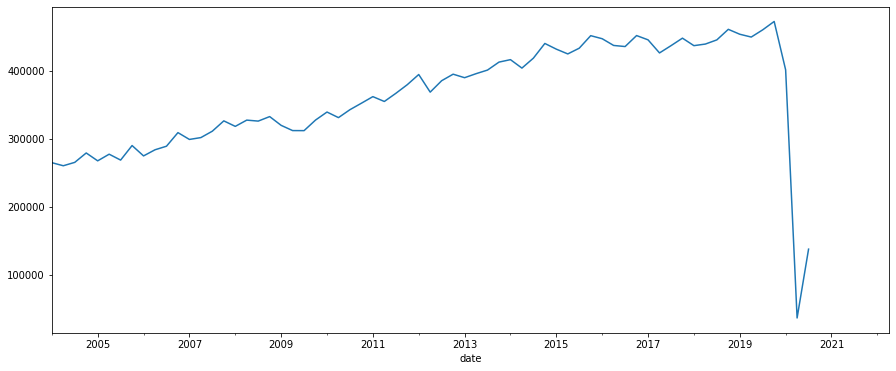

In [5]:
from helper_functions import load_railway_passengers, tidy_eu_rail_passengers

# load the data
rail_raw = load_railway_passengers(UPDATE = False)
# tidy it up
railpass = tidy_eu_rail_passengers(rail_raw)
# get UK data
uk_rail_pass = railpass[(railpass["country"] == "UK") &          # UK
                   (railpass["unit"] == "THS_PAS")          # Thousand passengers
                  ]["vals"].copy()                          # just get the values
# plot the data
uk_rail_pass.plot(figsize=(15, 6));

...the number of airline passengers from UK airports is the second most complex as it (mostly) has a consistent pattern of peaks and troughs thoughout the year, which (generally) slightly increases each year... until COVID hits...

__Note:__
If you turn `UPDATE = True`, it will save and load the latest airline data.

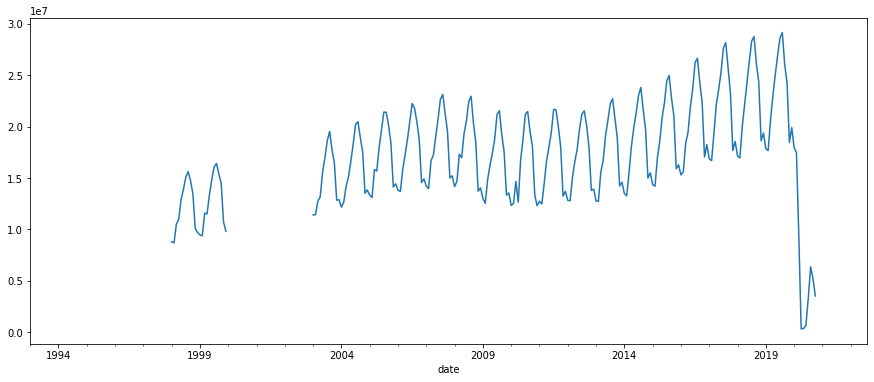

In [6]:
from helper_functions import load_airline_passengers, tidy_eu_passengers

# load the data
airline_raw = load_airline_passengers(UPDATE = False)
# tidy it up
airlines = tidy_eu_passengers(airline_raw)
# get UK data
uk_flight_pass = airlines[(airlines["country"] == "UK") &          # UK
                          (airlines["unit"] == "PAS") &            # passengers
                          (airlines["measurement"] == "PAS_BRD") & # passengers on board
                          (airlines["schedule"] == "TOT") &        # total
                          (airlines["coverage"] == "TOTAL")        # national and international
                         ]["vals"].copy() # just get the values

uk_flight_pass.plot(figsize=(15, 6));

...and finally the Covid data is the most complex as it has both increasing and decreasing values.

__Note:__
If you turn `UPDATE = True`, it will save and load the latest covid rate data from the UK government website.

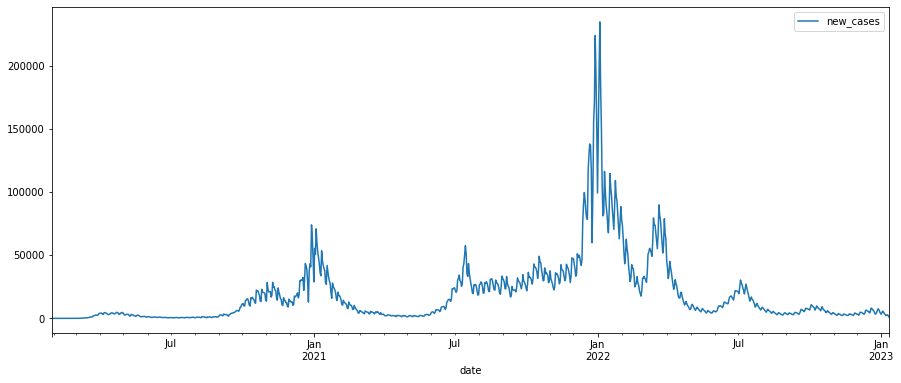

In [7]:
from helper_functions import load_covid, covid_prep

# load the covid data
covid_eng = load_covid(UPDATE=False)
# prep the data
covid_prepped = covid_prep(covid_eng)
# plot the data
covid_prepped.plot(figsize=(15, 6));

For this notebook, we will look at preparing the data and building models on these datasets. For example, a model for the flight passengers dataset (pre-covid) will look something like this...

__Notes:__ 
- `get_auto_flight_pass_model` is using a libary called `pmdarima` (discussed later). If you don't have it, you will get an error.
- `update` for the `get_auto_flight_pass_model` and `plot_forecasts` functions is whether you want to retrain the model and plot a new forecast.
- Loading the model I've already created will not work if you are not using the same pandas version (1.4.1)

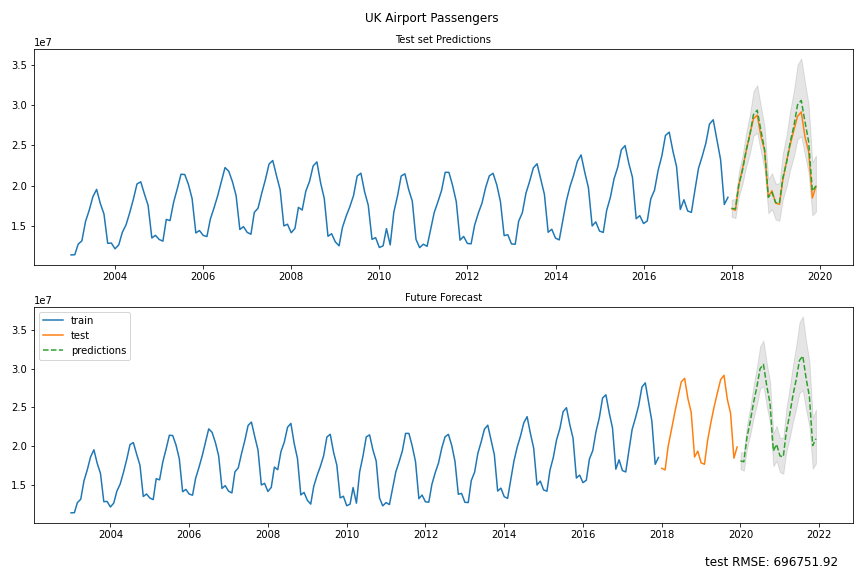

In [8]:
from helper_functions import prep_flights_test_train, get_auto_flight_pass_model, plot_forecasts

flights_train, flights_test = prep_flights_test_train(uk_flight_pass)
autoarima_model = get_auto_flight_pass_model(flights_train, "UK", trace = False, update = False)
plot_forecasts(autoarima_model, flights_train, flights_test, "UK", update = False)

... but there are a number of steps between us getting data and building a model like above. Lets start with preparing our data.

---

# 3. Data Preparation <a id='prep'></a>

The first dataset we are going to prep is the COVID case numbers, as although it the properties of the time series is more complex than the others we will look at, the preparation needed to get this data ready for modelling is actually easier. 

If you just load the data in from the government website its clear we are going to need to tidy it up a bit...

In [9]:
# display the first few rows
covid_eng.head()

,areaType,areaName,areaCode,date,newCasesBySpecimenDate,cumCasesBySpecimenDate,newFirstEpisodesBySpecimenDate,cumFirstEpisodesBySpecimenDate,newReinfectionsBySpecimenDate,cumReinfectionsBySpecimenDate
0,nation,England,E92000001,2023-01-11,1060,20489558,651,19059944,409.0,1429614.0
1,nation,England,E92000001,2023-01-10,2218,20488498,1402,19059293,816.0,1429205.0
2,nation,England,E92000001,2023-01-09,2811,20486280,1772,19057891,1039.0,1428389.0
3,nation,England,E92000001,2023-01-08,2347,20483469,1486,19056119,861.0,1427350.0
4,nation,England,E92000001,2023-01-07,2261,20481122,1524,19054633,737.0,1426489.0


This is just the covid infection data for England, and therefore only has one `areaCode`. 

For the sake of this workshop we are only going to look at `newCasesBySpecimenDate` which we will rename to `new_cases`.

In [10]:
covid = covid_eng[["date", "newCasesBySpecimenDate"]].copy()
covid.rename(mapper={"newCasesBySpecimenDate": "new_cases"},axis='columns', inplace=True)
covid.head()

,date,new_cases
0,2023-01-11,1060
1,2023-01-10,2218
2,2023-01-09,2811
3,2023-01-08,2347
4,2023-01-07,2261


Notice that at the moment `date` is curently stored as an "object" - meaning it is a string of text.

In [11]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1078 non-null   object
 1   new_cases  1078 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


This makes it difficult to work with - how do we extract the year, for instance? How does Python know what order the times go in to plot them? To let Python  know this is a date so need to turn this into a `date` object. To do this we are going to need to use Python's `DateTime` library, so lets take a quick detour away from our data and into looking into this package.

---

## 3.1. `DateTime`

Python's `DateTime` library is great for dealing with time-related data, and Pandas has incorporated this library into its own `datetime` series and objects. Below, we'll load in the `DateTime` library, which we can use to create a `datetime` object by entering in the different components of the date as arguments.

In [12]:
from datetime import datetime

Let's just start with an example date.

In [13]:
example_date = datetime(2022, 6, 7) # 07-06-2022
example_date

datetime.datetime(2022, 6, 7, 0, 0)

The components of the date are accessible via the object's attributes.

In [14]:
print("Year", example_date.year)
print("Month",example_date.month)
print("Day", example_date.day)
print("Hour", example_date.hour)
print("Minute", example_date.minute)
print("Second", example_date.second)
print("Micro-Second", example_date.microsecond)

Year 2022
Month 6
Day 7
Hour 0
Minute 0
Second 0
Micro-Second 0


Notice that from the hour is set to 0, this is because we didn't specify an hour, but if we needed this information we could.

In [15]:
example_date = datetime(2022, 6, 7, 8, 30) # 07-06-2022 08:30

print("Year", example_date.year)
print("Month",example_date.month)
print("Day", example_date.day)
print("Hour", example_date.hour)
print("Minute", example_date.minute)

Year 2022
Month 6
Day 7
Hour 8
Minute 30


---

### 🚩 Exercise 2

Convert the following strings to datetime format:

- 19 October 2021, 10:13 AM

- 31 May 2022, 09:30 AM

- 25 November 2021, 15:30 PM

In [16]:
%run ../scripts/show_solutions.py 12_ex2

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 3

Using the datetime objects above, print out their elements (e.g. month, hour)

In [17]:
%run ../scripts/show_solutions.py 12_ex3

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### `timedelta()`

If we wanted to add or subtract time from a date we could use a `timedelta` object to shift a `datetime` object. An example of when you may want to do this is when time is your index and you want to get everything that happened a week before a specific observation.

In [18]:
# Import timedelta() from the DateTime library.
from datetime import timedelta

# Timedeltas represent time as an amount rather than as a fixed position.
offset = timedelta(days=1)

# The timedelta() has attributes that allow us to extract values from it.
print('offset days', offset.days)

offset days 1


`datetime`'s `.now()` function will give you the `datetime` object of right now.

In [19]:
now = datetime.now()
print("right now:", now)

right now: 2023-01-22 11:32:49.752616


We can use `timedelta()` on the time now.

In [20]:
print("Past: ", now - offset)
print("Future: ", now + offset)

Past:  2023-01-21 11:32:49.752616
Future:  2023-01-23 11:32:49.752616


Note: The largest value a `timedelta()` can hold is days so if you want to shift by years you will have to convert it to days (see [here](https://docs.python.org/2/library/datetime.html)) or use `pd.DateOffset()`.

---

### 🚩 Exercise 4

Using the datetime objects created in exercise 3, find out the date 30 days before them.

In [21]:
%run ../scripts/show_solutions.py 12_ex4

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Right lets get back to our COVID data! 

The first step when working with time information is to convert it to a datetime format. The problem is that dates and times can be written in lots of different ways. For example, the following are all valid formats for the same datetime - and there are loads more! 

- 6/1/1930 22:00

- 06/01/1930 22:00

- 01/06/1930 22:00

- 1/6/1930 22:00

- 1930-06-01 22:00:00

- 1st June 1930 22:00

- June 1st 1930 10pm

Pandas ``to_datetime`` function will try to figure out what format it's reading, but it can sometimes take a while and might get it wrong.

In [22]:
%%time
# letting pandas figure out the format for itself - slow and may be wrong
pd.to_datetime(covid.date)

CPU times: total: 0 ns
Wall time: 2.08 ms


0      2023-01-11
1      2023-01-10
2      2023-01-09
3      2023-01-08
4      2023-01-07
          ...    
1073   2020-02-03
1074   2020-02-02
1075   2020-02-01
1076   2020-01-31
1077   2020-01-30
Name: date, Length: 1078, dtype: datetime64[ns]

You should generally try to figure out the format yourself and tell the function using a format code.

The codes used below are:

code | represents
--|--
%Y| year
%m | month
%d | day

In [23]:
%%time
# telling pandas the format.
# We use the - between %Y and %m as the format of our dates have
# -'s. 
covid.date = pd.to_datetime(covid.date, format='%Y-%m-%d')

covid.date

CPU times: total: 0 ns
Wall time: 999 µs


0      2023-01-11
1      2023-01-10
2      2023-01-09
3      2023-01-08
4      2023-01-07
          ...    
1073   2020-02-03
1074   2020-02-02
1075   2020-02-01
1076   2020-01-31
1077   2020-01-30
Name: date, Length: 1078, dtype: datetime64[ns]

---

### 🚩 Exercise 5

Convert the following strings to datetime format using `pd.to_datetime`:

- `"19 October 2021, 10:13 AM"`

- `"Oct 19 2021 - 10h13"`

- `"2021-10-19 10:13:29"`

__Hint__

To open the docs to grab the website for looking at datetime format codes (under the format info)
```
?pd.to_datetime
```

...or google "pandas strftime format codes"

In [24]:
%run ../scripts/show_solutions.py 12_ex5

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

You can see that each of these dates are now `datetime64` so have the properties of the datetime objects we created before.

In [25]:
print("Year", covid.date[0].year)
print("Month",covid.date[0].month)
print("Day", covid.date[0].day)

Year 2023
Month 1
Day 11


If we want a particular part it can be useful to define a function to do this...

In [26]:
def extract_day(datetime):
    return datetime.day

extract_day(covid.date[0])

11

...we can then apply this to the `date` column.

In [27]:
covid.date.apply(extract_day)

0       11
1       10
2        9
3        8
4        7
        ..
1073     3
1074     2
1075     1
1076    31
1077    30
Name: date, Length: 1078, dtype: int64

---

### 🚩 Exercise 6

Extract the year of each of the datetimes in the covid dataset

In [28]:
%run ../scripts/show_solutions.py 12_ex6

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
We need to use `.apply` if doing something more complicated e.g., classify dates into "this year", "last year", or "other".

In [29]:
def year_classifier(datetime):
    year = datetime.year
    if year < 2021:
        return 'this year'
    elif year < 2020:
        return 'last year'
    else:
        return 'other'
covid.date.apply(year_classifier)

0           other
1           other
2           other
3           other
4           other
          ...    
1073    this year
1074    this year
1075    this year
1076    this year
1077    this year
Name: date, Length: 1078, dtype: object

---
## 3.2. Filtering
Pandas lets you filter in the obvious way on datetimes. For example, you can do ```d1 < d2``` where `d1` and `d2` are datetime objects.

In [30]:
now

datetime.datetime(2023, 1, 22, 11, 32, 49, 752616)

In [31]:
earlier = pd.to_datetime('2021-09-01')
earlier

Timestamp('2021-09-01 00:00:00')

In [32]:
now < earlier

False

In [33]:
now > earlier

True

In [34]:
now == earlier

False

To filter on a dataframe, we need a mask. A mask is a column of `True`/`False` values. We make a mask by applying a comparison to a column:

In [35]:
twentyTwentyOne = pd.to_datetime('2021', format='%Y')
mask = covid.date < twentyTwentyOne
mask

0       False
1       False
2       False
3       False
4       False
        ...  
1073     True
1074     True
1075     True
1076     True
1077     True
Name: date, Length: 1078, dtype: bool

In [36]:
# use square brackets to filter the dataframe with the mask
display(covid[mask])

# or can just use 
# covid[covid.date < twentyTwentyOne]

,date,new_cases
741,2020-12-31,47823
742,2020-12-30,64243
743,2020-12-29,74058
744,2020-12-28,40846
745,2020-12-27,43250
...,...,...
1073,2020-02-03,18
1074,2020-02-02,1
1075,2020-02-01,0
1076,2020-01-31,0


---

### 🚩 Exercise 7

Find how many new cases have been reported since June 1st 2021.

In [37]:
%run ../scripts/show_solutions.py 12_ex7

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
After converting the column containing time data from object to `datetime`, for filtering it is also useful to make the index of the DataFrame a `datetime`.

__Note:__ Both `sort_values` and `set_index` can use `inplace=True` if you dont want to use the assignment (`=`), and instead overwrite the current object. For example `covid.sort_values(by='date', inplace=True)` would overwrite the `covid` data with one where the values are sorted by date.

In [38]:
# sort earliest to most recent
covid = covid.sort_values(by='date')
# Set the date to the index 
covid = covid.set_index('date')

# Preview the data 
covid.head()

,new_cases
date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,18


With the index as a datetime, it is also easy to plot the data with matplotlib.

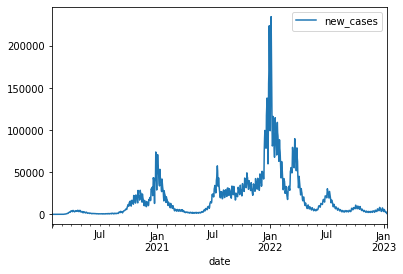

In [39]:
covid.plot()
plt.show()

---

### 🚩 Exercise 8

By filtering your data, plot only the covid cases that happened in 2021.

In [40]:
%run ../scripts/show_solutions.py 12_ex8

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
## 3.3. Resampling

The Covid data is nice and regular giving us one value per day. However what do we do when the data doesn't look like that?

Lets have a look at another dataset, UFO sightings!

In [41]:
import pandas as pd

ufo = pd.read_csv('./Data/ufo.csv')

ufo.head()

,City,Colors Reported,Shape Reported,State,Time
0,Ithaca,NaN,TRIANGLE,NY,6/1/1930 22:00
1,Willingboro,NaN,OTHER,NJ,6/30/1930 20:00
2,Holyoke,NaN,OVAL,CO,2/15/1931 14:00
3,Abilene,NaN,DISK,KS,6/1/1931 13:00
4,New York Worlds Fair,NaN,LIGHT,NY,4/18/1933 19:00


Lets do some data cleaning to get this data ready to be used as a timeseries.

In [42]:
from helper_functions import clean_ufos

ufo = clean_ufos(ufo)

ufo.head()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-01 22:00:00,Ithaca,NaN,TRIANGLE,NY
1930-06-30 20:00:00,Willingboro,NaN,OTHER,NJ
1931-02-15 14:00:00,Holyoke,NaN,OVAL,CO
1931-06-01 13:00:00,Abilene,NaN,DISK,KS
1933-04-18 19:00:00,New York Worlds Fair,NaN,LIGHT,NY


---

### 🚩 Exercise 9 (extra)

Write your own function to clean the data as above (change `Time` to a `datetime` and set as an index).

In [43]:
%run ../scripts/show_solutions.py 12_ex9

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Lets stop a second and think about out the UFO dataset. Is it a time series? 

It's a little ambiguous, but normally when we talk about time series data, we mean that recordings are made <em>at regular time intervals</em>. So we have a single (usually numeric) value for each day (or each month, or each second, ...)

So the ufo dataset isn't what we'd normally call a time series, because it has irregular intervals, and can have multiple records at the same time. However, we can convert it to a more regular time series by <em>resampling</em>. To do this, we need the time as the index of the dataframe, which is usual for time series.

To start with, we could resample to get a value for every month. Like `groupby`, `resample` needs an aggregate function to know how to combine multiple values in the same time period. For example we can aggregate into monthly data...

In [44]:
ufo.resample('M').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-30,2,0,2,2
1930-07-31,0,0,0,0
1930-08-31,0,0,0,0
1930-09-30,0,0,0,0
1930-10-31,0,0,0,0
...,...,...,...,...
2014-05-31,593,197,535,593
2014-06-30,709,216,669,710
2014-07-31,1006,386,929,1006


...yearly...

In [45]:
ufo.resample('Y').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-12-31,2,0,2,2
1931-12-31,2,0,2,2
1932-12-31,0,0,0,0
1933-12-31,1,0,1,1
1934-12-31,1,0,1,1
...,...,...,...,...
2010-12-31,4154,849,3769,4154
2011-12-31,5087,1278,4650,5089
2012-12-31,7263,2239,6679,7263


...or daily.

In [46]:
ufo.resample('D').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-01,1,0,1,1
1930-06-02,0,0,0,0
1930-06-03,0,0,0,0
1930-06-04,0,0,0,0
1930-06-05,0,0,0,0
...,...,...,...,...
2014-09-01,25,7,22,25
2014-09-02,15,3,13,15
2014-09-03,24,8,23,24


Resampling can also be used to change the level of granularity. For example, if you have hourly data and you want to study long term trends over a year, you might resample to a daily, weekly, or monthly level with a `sum` or `mean` as the aggregate.

In this case lets `count` the number of sightings per year to use as our time series.

In [47]:
# make this resampling permanent, and also extract only the state column, 
# as that has no nulls in
ufo_state_count = ufo.resample('Y').count()['State']
ufo_state_count

Time
1930-12-31       2
1931-12-31       2
1932-12-31       0
1933-12-31       1
1934-12-31       1
              ... 
2010-12-31    4154
2011-12-31    5089
2012-12-31    7263
2013-12-31    7003
2014-12-31    5382
Freq: A-DEC, Name: State, Length: 85, dtype: int64

If we plot the data we can see that the number of sightings has been increasing, peaking in 2012.

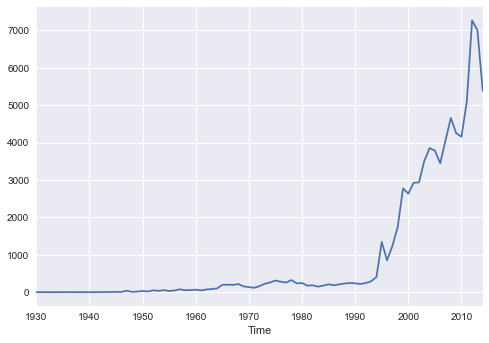

In [48]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

ufo_state_count.plot();

---

### 🚩 Exercise 10

Using the UK daily covid rate data resample to weekly counts level and plot a graph

In [49]:
%run ../scripts/show_solutions.py 12_ex10

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 13 (Extra)

See if you can create the `tidy_eu_passengers` function to prepare and clean the EU airline passengers data (`airline_raw`) yourself. You'll need to:
- Rename columns
- Select only monthly data
- Change the date to a datetime and set as the index
- Replace the country codes with country names
- Change missing values to `NAN`
- Change values to a float
- Sort from the earliest date to the most recent

__TODO__
- Change numbering of exercise

In [50]:
%run ../scripts/show_solutions.py 12_ex13

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 4. Exploratory Data Analysis <a id='eda'></a>

Like any machine learning project, we first need to explore our data to help us understand it better, so that we can choose appropriate models and parameters.

## 4.1. Trends

A trend is any long-term change in the value we're measuring. For example, between the start of December 2020 and the second week of January 2021, there was an upward trend in Covid cases.

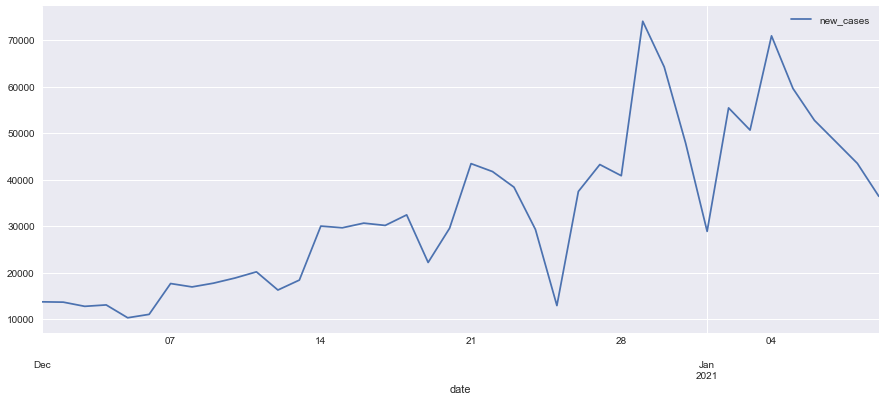

In [51]:
# let's filter our data to look at the middle section more closely
# using ISO 8601 format, `format=` is optional
start_date = pd.to_datetime('2020-12-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2021-01-10', format='%Y-%m-%d')

# create the mask
after_start = covid.index >= start_date
before_end = covid.index < end_date
mask = after_start & before_end

# plot
covid[mask].plot(figsize=(15,6));

A basic fit for this data would be a straight line (or polynomial degree 1; `order=1`).

__Note:__ A regression model here is useful for demonstrating the trend visually but is __not__ the best model for time-series data. We'll see some better models later.

C:\Users\David_Elliott\AppData\Local\Temp\ipykernel_23628\208153991.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates_.dt.date)


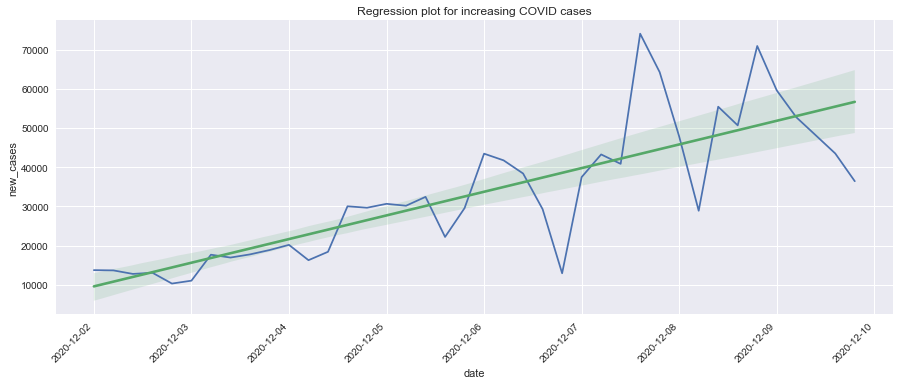

In [52]:
import seaborn as sns

# make a copy of the data for plotting
df = covid[mask].copy()

# reset the index so its in the columns
df.reset_index(inplace=True)

# save the dates
dates_ = df.date

# regplot doesn't play nice with datetimes so lets convert them to
# ordinal values
df["date"] = df.date.map(pd.Timestamp.toordinal)

# create a canvas for the plot
fig, ax = plt.subplots(figsize=(15,6))

# add a line plot
sns.lineplot(x='date', y='new_cases', data=df, ax=ax)

# add the regression line
sns.regplot(x='date', y='new_cases', data=df, ax=ax, scatter=False, order=1)

# set our labels back to the dates
ax.set_xticklabels(dates_.dt.date)

# legible labels
fig.autofmt_xdate(rotation=45, ha='right')

# add plot title
plt.title("Regression plot for increasing COVID cases")

# display figure
plt.show()

---

### 🚩 Exercise 11

Is above the best fit? 
- Visually change the degree of the polynomial (`order=`) and see if you think there is a better fit. 
- What happens as you keep increasing the degree?

In [53]:
%run ../scripts/show_solutions.py 12_ex11

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Trends may "change direction" going from an increasing trend to a decreasing trend. Trends can only be measured within the scope of the data collected; there may be trends that are unmeasurable if the data are not complete. For example, if we were to increase the size of the mask from before...

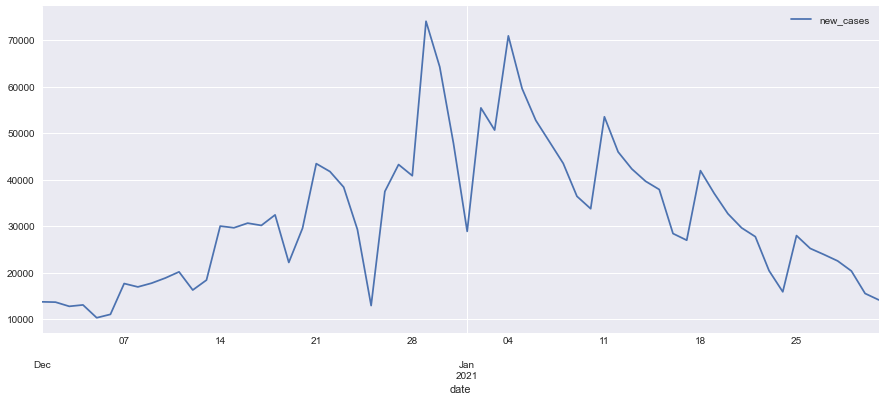

In [54]:
# let's filter our data to look at the middle section more closely
# using ISO 8601 format, `format=` is optional
start_date = pd.to_datetime('2020-12-01')
end_date = pd.to_datetime('2021-02-01', format='%Y-%m-%d')

# create the mask
after_start = covid.index >= start_date
before_end = covid.index < end_date
mask = after_start & before_end

# plot
covid[mask].plot(figsize=(15,6));

---

### 🚩 Exercise 12

Plot the a polynomial regression line (`order` > 1) on the data above (with the wider mask).

In [55]:
%run ../scripts/show_solutions.py 12_ex12

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Another way we can evaluate trends is by calculating aggregates (mean, median, etc). If we look at the mean/median value of something (i.e. sales, customers) per week/month/year you can start to see trends. Again we can use `.resample()` to calculate aggregates of a given time period. For example if, if you type `"M"` with `.mean()` you will calculate the mean covid cases for every month in the dataset.

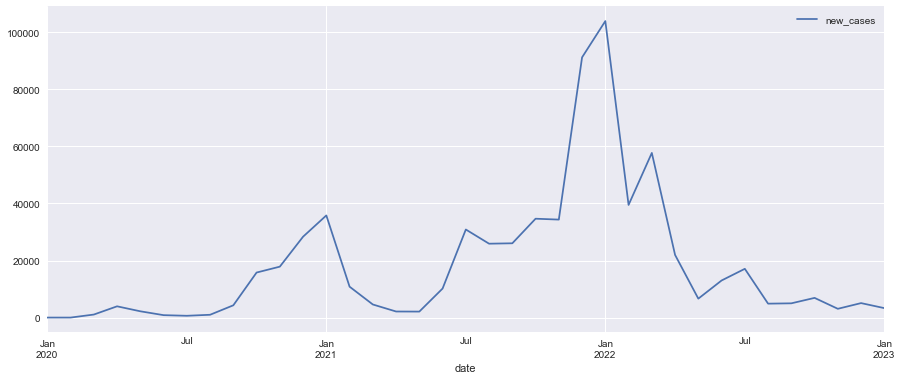

In [56]:
covid_resample = covid.resample("M").mean()
covid_resample.plot(figsize=(15,6));

---
### Rolling Statistics

An advantage of time series is that we can roll statistics over time. For example, a rolling mean is the mean of a moving window across a time period. Pandas has several inbuilt functions that allow us to calculate rolling statistics.

This graph is "spiky" because a lot of tests done on weekends aren't reported until the following Monday or Tuesday, so we get artificially low numbers at weekends, and high numbers at the start of the week. This is an artefact of the way the data are collected, not of the actual variable of interest (covid case numbers).

We can fix this with a 3-day rolling average, which will smooth out these spikes to give a more accurate estimate of the actual number of new cases each day.

In [57]:
covid.rolling(window=3).mean()

,new_cases
date,
2020-01-30,NaN
2020-01-31,NaN
2020-02-01,0.333333
2020-02-02,0.333333
2020-02-03,6.333333
...,...
2023-01-07,3142.666667
2023-01-08,2605.000000
2023-01-09,2473.000000


There are two missing values at the start of this dataframe. This is because at the start there aren't enough data points to average - each data point here is the average of 3 consecutive datapoints in the original time series, so you can only start forming that average by the 3rd data point.

Where the missing values appear in your data will depend on the type of rolling window you use. You could for example use a centred rolling window...

In [58]:
covid.rolling(window=3, center=True).mean()

,new_cases
date,
2020-01-30,NaN
2020-01-31,0.333333
2020-02-01,0.333333
2020-02-02,6.333333
2020-02-03,6.333333
...,...
2023-01-07,2605.000000
2023-01-08,2473.000000
2023-01-09,2458.666667


Using ```center=True``` means the rolling window is centred on the datapoint of interest. So e.g., Monday's rolling average value will be the average of Sun, Mon, Tue, whereas with a non-centred rolling average it will be the average of Sat, Sun, Mon. Centred rolling averages are better for historical analysis, because each rolling average point is based on the closest possible values, so is more accurate, _but_ it means you get nulls in the rolling average at the start _and end_ of the time series (because for today's rolling average you'd need to know tomorrow's data), so if you want to use the rolling average to forecast, you can't use a centred version.

Also, when using `center=True`, you should use an odd window size, since an even number of dates doesn't have a centre point. For non-centred rolling averages, even or odd window sizes are fine.

If we plot our rolling windowed data out you can see the rolling average is "smoother", but still not totally smooth. 

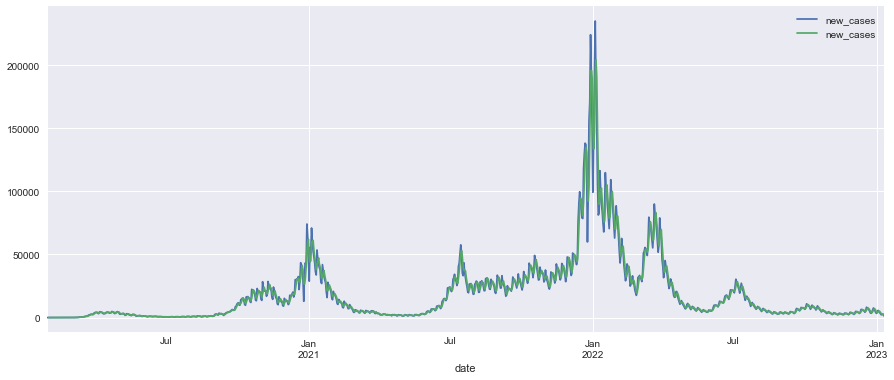

In [59]:
fig, ax = plt.subplots(figsize=(15,6))
covid.plot(ax=ax)
covid.rolling(window=3).mean().plot(ax=ax);

Using a larger window for the rolling average will improve this. 7 would be a window size to look at weekly trends.

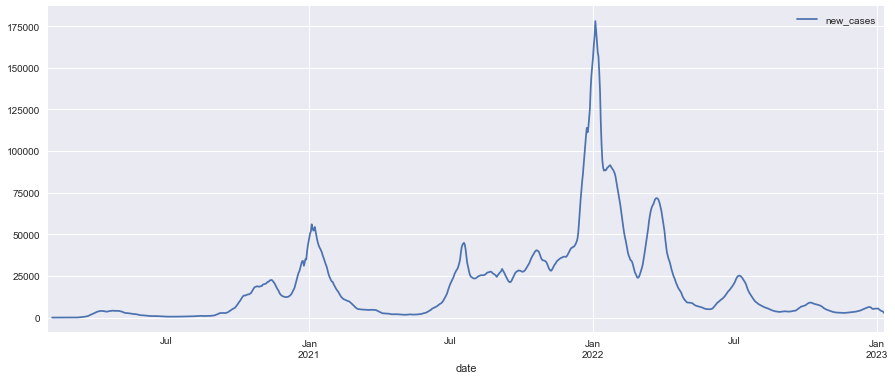

In [60]:
covid.rolling(window=7).mean().plot(figsize=(15,6));

Rolling averages smooth out spikes and changes in the data; with the bigger the window size, the more smoothing. So a fairly small window size like 3 (above) smooths out the most aggressive spikes, but leaves a lot of the fine detail intact. A larger window size like 7 (also above) smooths out more, but still leaves large-scale behaviour clear. A huge window size (below) will start to obscure even the overall structure. 

__Note:__ You should never use an overly large window size.

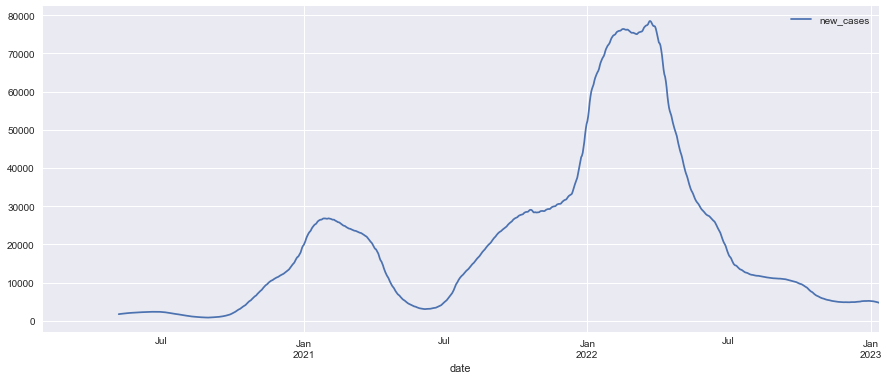

In [61]:
# never use a window size this big in practice!
covid.rolling(window=100).mean().plot(figsize=(15,6));

Rolling averages are good for looking at the overall <em>trend</em> of a time series, without getting distracted by the fine detail. When looking at trends, and other properties of time series, it can be useful to look at other rolling statistics:

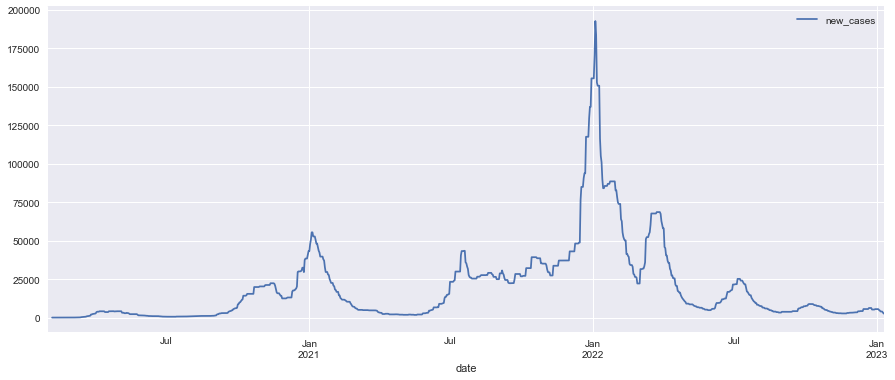

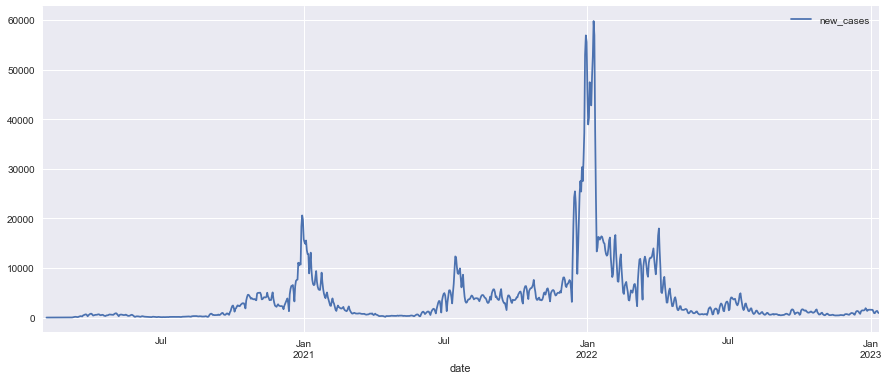

In [62]:
# can also calculate other rolling statistics, e.g., rolling median
covid.rolling(window=7).median().plot(figsize=(15,6));
# rolling standard deviation - tend to use a larger window size for this.
covid.rolling(window=7).std().plot(figsize=(15,6));

Comparing the rolling standard deviation to the actual data, we see that we get larger standard deviation (i.e., bigger short-term fluctuations in the data) when the value of the series is higher. This is <em>heteroskedasticity</em>, which literally means "different scatter" in Greek. 

A series is heteroskedastic if it has bigger fluctuations at some times than at others and is homoskedastic ("same scatter") if it has similar size fluctuations at all times.

A lot of time series models don't work well with heteroskedastic data, so the data need to be transformed to make them homoskedastic (e.g. taking the logarithm). There are also some models designed to work with heteroskedastic data, so those can be used instead.

Lets apply what we have learnt so far to another set of data, EU airline passengers.

---

### 🚩 Exercise 14

Plot the `uk_flight_pass` data and discuss their trends. 

- Do you think we need to do any cleaning?
- Does smoothing out spikes in the data help give a more accurate estimate? 
- Is it a homoskedastic time series?

In [63]:
%run ../scripts/show_solutions.py 12_ex14

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
From now on, for the `uk_flight_pass` data, we are going to focus on predicting the travel pre-covid so won't use data from 2020 onwards for now.

In [64]:
uk_flight_pass = uk_flight_pass.loc['2003-01-01':'2019-12-01']

We'll also set a frequency for this data, this is so later the models know the dates are each the beggining of the calendar month and will be able to account for this and making predictions with the same intervals.

In [65]:
# set a frequency for the data
uk_flight_pass.index.freq = 'MS' # 'MS' = calendar month begin

---

### Shifting and Lagging

Another common operation on time series data to look at trends is to shift or lag values backward and forward in time. This can help us calculate the percentage of change from sample to sample (so we can calculate things such as  percentage daily change or other KPI's). 

Pandas has a `.shift()` method for shifting the data in a DataFrame.

In [66]:
display(covid.head(10))

covid_forward = covid.shift(1)
display(covid_forward.head(10))

,new_cases
date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,18
2020-02-04,0
2020-02-05,1
2020-02-06,0
2020-02-07,0


,new_cases
date,
2020-01-30,NaN
2020-01-31,1.0
2020-02-01,0.0
2020-02-02,0.0
2020-02-03,1.0
2020-02-04,18.0
2020-02-05,0.0
2020-02-06,1.0
2020-02-07,0.0


Notice that the first row now contains NaN values because there wasn't a previous day's data to shift to that day. Also notice the values have been shifted and not the datetime. If you want to keep the dates correct after lagging you'll also need to move the index...

In [67]:
# indicate it is a daily frequency - you need a freqency to shift
covid_forward.index.freq = 'd'
# move the dates back
covid_forward.index = covid_forward.index.shift(-1)
covid_forward.head(10)

,new_cases
date,
2020-01-29,NaN
2020-01-30,1.0
2020-01-31,0.0
2020-02-01,0.0
2020-02-02,1.0
2020-02-03,18.0
2020-02-04,0.0
2020-02-05,1.0
2020-02-06,0.0


---

### 🚩 Exercise 15

Shift the covid cases by a week.
- Plot the lagged data vs the actual.

In [68]:
%run ../scripts/show_solutions.py 12_ex15

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Lags can be used to calculate the changes in the values you are tracking with your time series data. In this case, we can use Pandas' `.shift()` method to look at the changes in covid cases based on the previous day. 

In [69]:
covid_change = covid.copy()

covid_change["change"] = covid - covid.shift(1)
covid_change.head(20)

,new_cases,change
date,,
2020-01-30,1,NaN
2020-01-31,0,-1.0
2020-02-01,0,0.0
2020-02-02,1,1.0
2020-02-03,18,17.0
2020-02-04,0,-18.0
2020-02-05,1,1.0
2020-02-06,0,-1.0
2020-02-07,0,0.0


---

### 🚩 Exercise 16

Shift the `uk_flight_pass` data to get the monthly change.

__Note__
- You may need to use `fill_value=0` in the `.shift`.

In [70]:
%run ../scripts/show_solutions.py 12_ex16

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

We can also use lags to start to look into seasonality.

---

## 4.2. Seasonality

A time series is <em>seasonal</em> if it has a regular repeating pattern <strong>with a fixed, known frequency</strong>. The number of data points before the pattern repeats is called the <em>seasonal period</em>. Monthly data, for example, often has seasonality with period 12 (each year), hourly data often has period 24 (each day), etc.

A time series could also be <em>cyclic</em> or has <em>cycles</em> if it has repeating patterns <strong>at irregular intervals</strong>. So repeating behaviour is seasonal if it always happens at fixed intervals, and cyclic if it happens irregularly. Cyclic data is much harder to forecast accurately, because you don't know when the next cycle will occur; often the best you can do is say on average the level of the series. Seasonal data however can often be accurately forecast.

Lets look at our `uk_flight_pass` data. We can make a good assumption that there is going to be a pattern that is similar across months (e.g. january in 2018 may be similar to january 2019). We can observe this by plotting the original data as well as a shifted version.

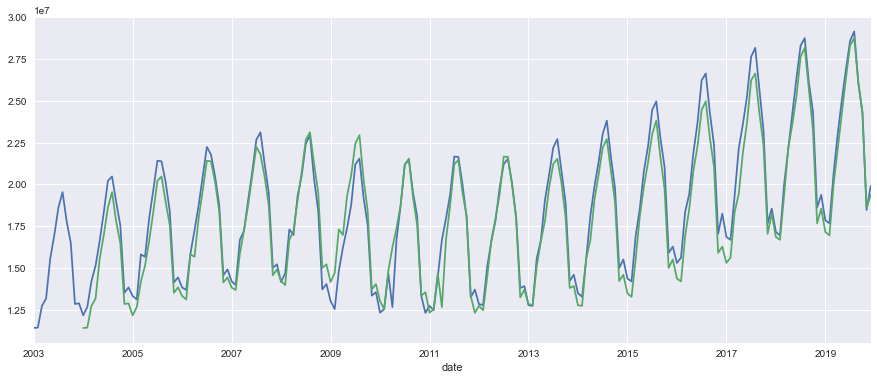

In [71]:
fig, ax = plt.subplots(figsize=(15,6))
uk_flight_pass.plot(ax=ax)
uk_flight_pass.shift(12).plot(ax=ax)
plt.show()

Indeed, if we quantify this relationship with a correlation (each point with its 12 month lagged version), we see a very high correlation.

In [72]:
from scipy.stats import pearsonr

# we need to shift the first 12 values as the function cannot take na's
corr, p = pearsonr(uk_flight_pass.iloc[12:], uk_flight_pass.shift(12).iloc[12:])

print("Correlation: " + str(round(corr,3)))
print("P-Value: " + str(round(p,3)))

Correlation: 0.977
P-Value: 0.0


As we can see, 0.98 is a very strong correlation and the p-value indicates that the probability of seeing a correlation this strong (or stronger) from random data is absolutely tiny, so its unlikely that this correlation is just down to luck.

__Note:__ 
If you don't round, you will see the p-value in scientific notation ("e-129"). The value 3.60e-129 means $3.6\times 10^{-129}$.

So currently we have observed that the data is highly correlated with itself at lag 12 (12 months difference; potential evidence for seasonality) but we can extend this and see if the series is correlated with itself at multiple different lags using <em>autocorrelation</em>.

We normally the __AutoCorrelation Function (ACF)__ to calculate the correlation of the series with itself at several different lags (shifts) and plots those correlation values. It also gives us an idea of significance, anything in the blue shaded area is not a significantly strong correlation.

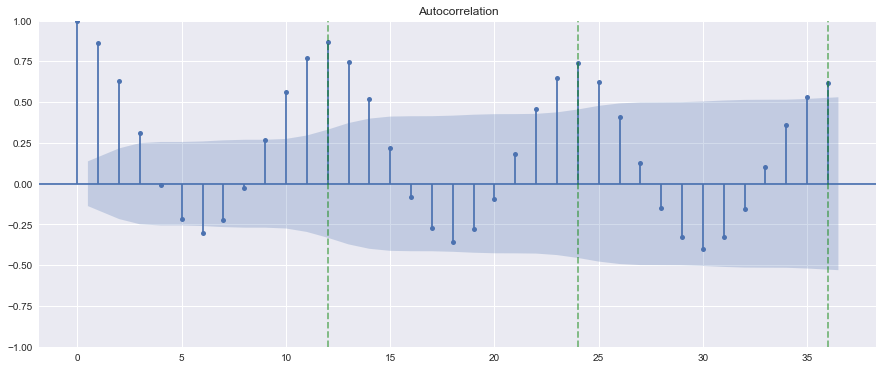

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

# get the canvas
fig, ax = plt.subplots(figsize=(15,6))

# plot the acf
plot_acf(uk_flight_pass, lags=36, ax=ax)

# add green lines to show every 12 months
plt.axvline(x=12, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=24, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=36, color='g', linestyle='--', alpha=0.5)

plt.show()

We can see that the value in the last month is typically highly correlated with the current month (lag 1). This makes sense because with a time series the current value is often dependent on the previous value (there is unlike to all of a sudden be loads more or fewer passengers in Feburary than January). This correlation then decreases as we get further away from the current month, then at lag 9 starts to get similar again as we get closer to the same month but a year apart (which again we would expect).

Above is a good example of seasonality in ACF plots as seasonality is visible by a repeating spike every multiple of $m$ (where $m$ is the seasonal period, e.g., $m=12$). Cyclic behaviour does not show up in the ACF plot, because when you shift irregular cycles, they don't line up, so you don't get a strong correlation.

However, there is a problem in using ACF on strongly trended data with weak seasonality as the trend can obscure the seasonality. For example if we look at the number of rail passengers in the UK we'll see exactly that.

__Note:__ Here we are using the "Passengers transported (detailed reporting only) - (quarterly data)" data on the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view). Its similar to the flights passenger data but instead reported quarterly rather than monthly.

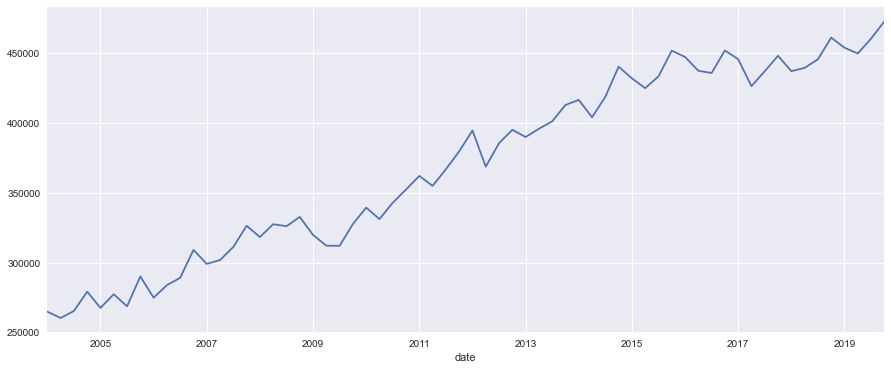

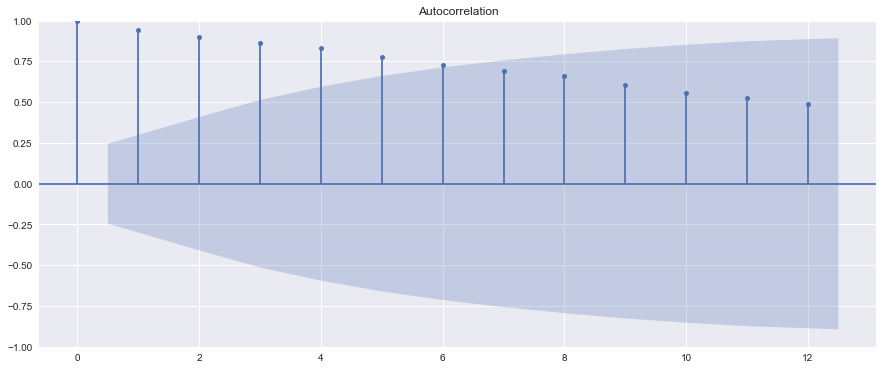

In [74]:
# don't include 2020
uk_rail_pass = uk_rail_pass.loc[:"2019-10-01"]

# plot the data out
uk_rail_pass.plot(figsize=(15,6))
plt.show()

# plot the acf
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(uk_rail_pass, lags=12, ax=ax)
plt.show()

As we can see in the first plot, this data has a very clear trend upwards over time. Trend (either upwards or downwards) is visible in an ACF plot (second plot) by a gradual decrease in the values. Above in the rail data we may expect to see a yearly trend (lag 4), where values from Q1 in one year is similar to values from Q1 in a previous year. However we cannot see this in the ACF because the strong trend is obsuring this seasonality. To observe whether the rail data has seasonality in the ACF plot we will first then have to remove the trend.

To capture trend, we can use integration/differencing. To do this we look at the difference from one value of the time series to the next, rather than the raw values (like we did when we shifted the data and looked at the change). This often removes trend - because if a time series is trending upwards at a steady rate, then the difference from one observation to the next is a consistent positive value - so roughly a constant, with no trend.

We can use `.diff` in pandas to achieve this.

In [75]:
# make a temporary copy for demonstration
uk_rail_pass_ = pd.DataFrame(uk_rail_pass.copy())

# get the difference
uk_rail_pass_["difference"] = uk_rail_pass.diff()
uk_rail_pass_

,vals,difference
date,,
2004-01-01,264878.0,NaN
2004-04-01,260330.0,-4548.0
2004-07-01,265318.0,4988.0
2004-10-01,279146.0,13828.0
2005-01-01,267571.0,-11575.0
...,...,...
2018-10-01,461161.0,15546.0
2019-01-01,453939.0,-7222.0
2019-04-01,449794.0,-4145.0


Indeed if we plot the data you can see that comparatively the differenced data (at the bottom) does not trend upwards anymore.

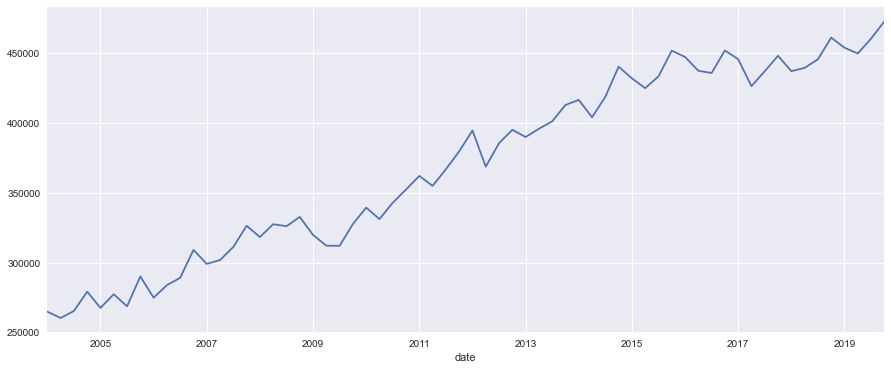

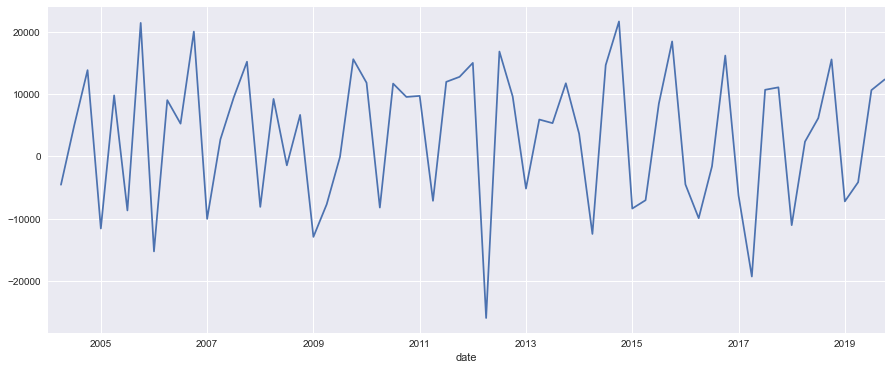

In [76]:
# plot the data
uk_rail_pass.plot(figsize=(15,6))
plt.show()

# plot the difference to remove trend
uk_rail_pass.diff().plot(figsize=(15,6))
plt.show()

Indeed if we look at the ACF on the differenced rail data, you can more more clearly see the seasonal spike every quater as it is no longer obscured by the trend.

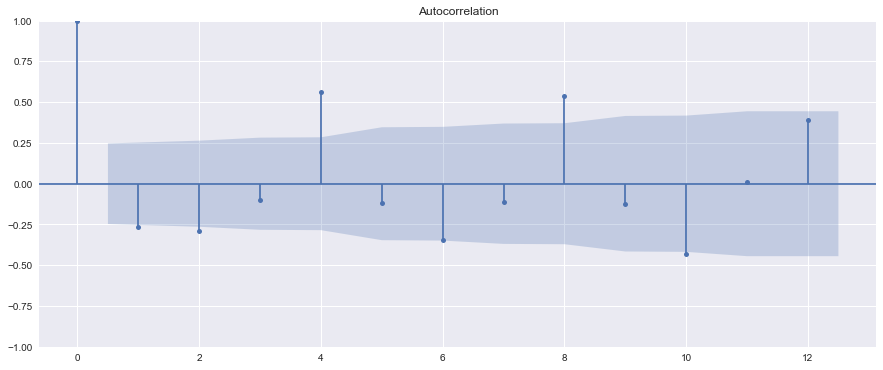

In [77]:
# plot the ACF on the differenced data
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(uk_rail_pass.diff().dropna(), lags=12, ax=ax)
plt.show()

---

### 🚩 Exercise 17

Difference the `uk_flight_pass` data and see how this changes your ACF plot.

In [78]:
%run ../scripts/show_solutions.py 12_ex17

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values, describing how well the present value is related with its past values. A time series have all sorts of components like trends, seasonality, cycles, and residual and each of these components will represent an underlying pattern. 

- **Trend**: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes, we will refer to a trend “changing direction” when, for example, it might go from an increasing trend to a decreasing trend.

- **Seasonal**: A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.

- **Residual**: The leftover or error component after removing the trend and seasonality.

We can see these components in our rail data using `seasonal_decompose`.

__Note:__ We're using `period=4` because the rail data is quaterly remember and we have seen evidence in our ACF that there is a seasonal pattern. Don't use `seasonal_decompose` if you think there is not seasonality in your data! This method will assume you have checked for this first.

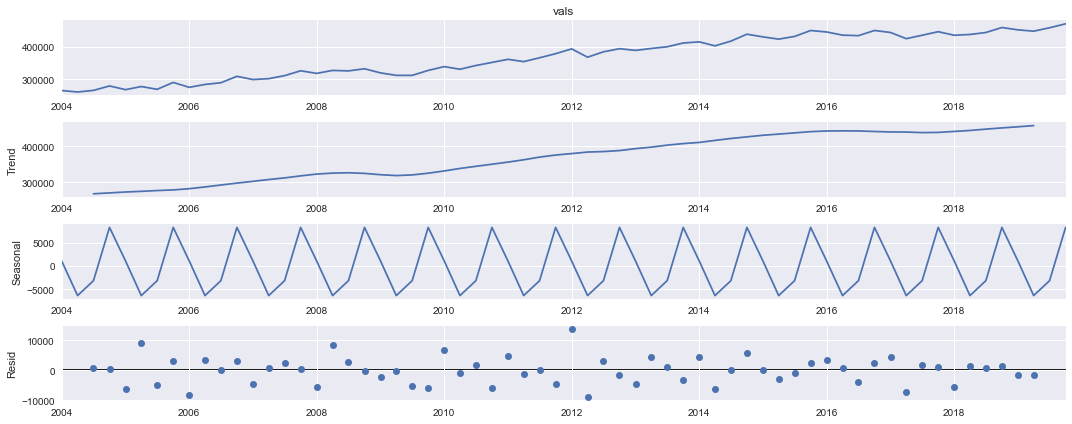

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

rail_decomp = seasonal_decompose(uk_rail_pass, period=4) # older versions of statsmodels have freq instead of period
fig = rail_decomp.plot()    # plot the decomposition
fig.set_size_inches((15,6)) # set plot size
fig.tight_layout()          # Tight layout to realign things
plt.show()

ACF considers all these components when calculating the correlation between a current value and a previous value - hence it’s a ‘complete auto-correlation plot’.

We could also use a __partial auto-correlation function (PACF)__. Instead of finding correlations of a present value with its lags, we could find the correlation of the residuals (what remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’. We are removing already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling.

Like ACF, PCAF doesn't work as well when we have non-stationary data (a time series is "stationary" if it looks basically centered around some number). As both the rail and flight passenger data is non-stationary due to the trend, we need to difference first before doing the PCAF as well.

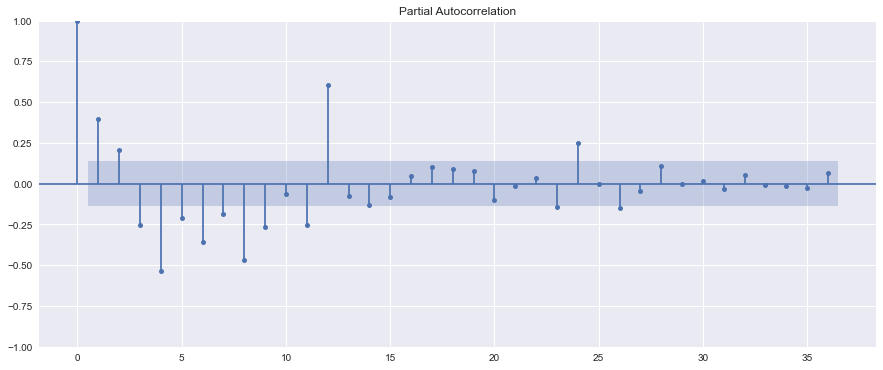

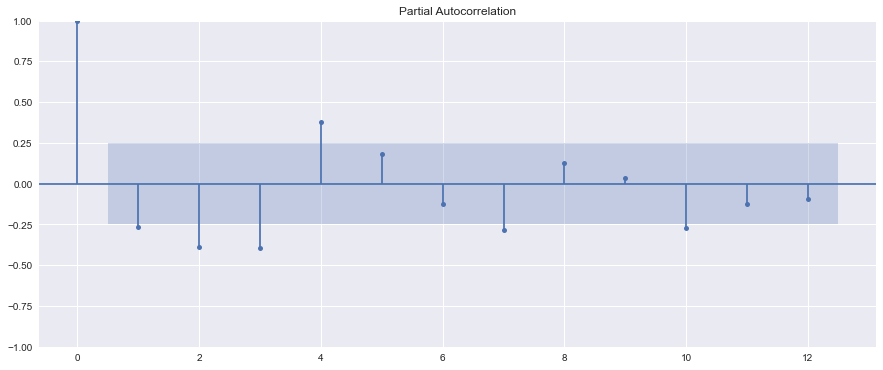

In [80]:
from statsmodels.graphics.tsaplots import plot_pacf

# plot the PACF for the flights passengers
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(uk_flight_pass.diff().dropna(), lags=36, ax=ax, method='ywm');
plt.show()

# plot the PACF for the rail passengers
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(uk_rail_pass.diff().dropna(), lags=12, ax=ax, method='ywm');
plt.show()

This is further confirming that even when accounting for the information in previous lags, the flights data still has a 12 month seasonality and the rail data a 4 quater seasonality.

Differencing can also make it easier to spot heteroskedasticity, which as we mentioned can be an issue for some time series models. The flight passengers data is not heteroskedastic as it has bigger fluctuations in later months than earlier ones (look at the negative numbers after differencing).

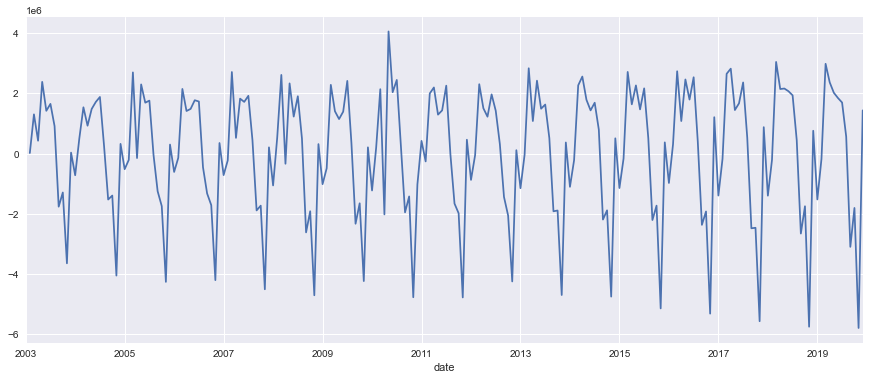

In [81]:
uk_flight_pass.diff().plot(figsize=(15,6));

As previously mentioned, there are ways to deal with heteroskedastic data such as taking the logarithm.

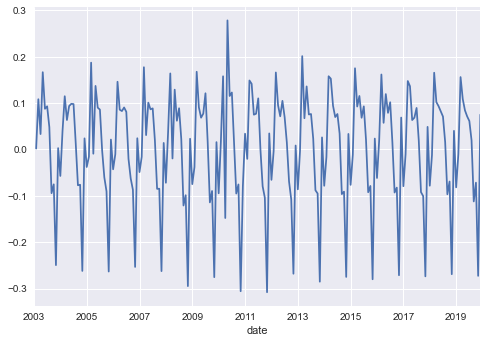

In [82]:
import numpy as np

# make a tempory copy
uk_flight_pass_ = pd.DataFrame(uk_flight_pass.copy())

# log transform the data
uk_flight_pass_['log'] = np.log(uk_flight_pass_)

# difference the log transformation and plot
uk_flight_pass_['log'].diff().plot()
plt.show()

For heteroskedastic data, the default `seasonal_decompose` doesn't always work very well. You sometimes get a better decomposition with a multiplicative method (`model='multiplicative'`). A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.

---

### 🚩 Exercise 18

Resample the covid data to get the total cases per week and look at the autocorrelation/partial-autocorrelation over a year (52 lags). 
- How many weeks ahead do you think are reliably correlated?
- Do you think there is any seasonality?
- Do you think the data is non-stationary?

In [83]:
%run ../scripts/show_solutions.py 12_ex18

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 19

Using `seasonal_decompose`, decompose the flight passenger data. 
- Do you think this decomposition has worked well?
- Do you think its appropriate to use this on the COVID data?

In [84]:
%run ../scripts/show_solutions.py 12_ex19

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 5. Model Exploration/Refinement <a id='explore'></a>

So far we have been doing _"time-series analysis"_ by extracting meaningful statistics and characteristics from the data. Now we are going to use that information to do _"time-series forecasting"_, where we predict future values based on previously observed values. Like other predictive models discussed in previous workbooks, future values are predicted using historical values, and we will evaluate the models on how they perform on seen and unseen data. However, unlike previous models, the predictions from earlier time points will also make up the inputs for prediction.

Another unique quality of time-series compared to what we have seen before is that the data is time dependent. Models such as linear regression assume that the observations are independent - here we are assuming they also have trend or seasonality (meaning observations are dependent on their previous values). Because of this, we are assuming there is autocorrelation in our data unlike in regression modelling where we assume residuals/error terms are independent of one another.

__Note:__ [This video](https://www.youtube.com/watch?v=ZoJ2OctrFLA&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&ab_channel=ritvikmath) does a good job of explaining this.

---

## 5.1. Train-test split

Lets first split our data into training and testing subsets. This allows us to train our model and compare its prediction with the testing subset. If satistifed with the model performance, we can then retrain it with all the data and then forecast future values.

As time series data have a natural temporal ordering, we need to account for this in our splits. Because these data are ordered, we **cannot choose training and testing examples at random.** As we are attempting to predict _a sequence of future values_, we must train on values from earlier (in time) in our data and then test our values at the end of the period (so no `train_test_split()`).

For our UK flights data, lets therefore use the data from 2003-2017 to predict the UK flights in 2018 and 2019.

__Notes:__ 
- Technically we should have done this train/test split as early in our analysis as possible, before EDA typically (see workbooks 1 & 2 for more on this).
- If we are going to do lots of model refinement you probably would want to also consider a validation set or do cross-validation (see extra section)

In [85]:
# datetime value to start the test set
test_start = pd.to_datetime('2018-01-01')

# get the training set which has all values upto the month before the testset
flights_train = uk_flight_pass.loc[:test_start-pd.DateOffset(months=1)]
# get all values from and including the test set day
flights_test = uk_flight_pass.loc[test_start:]

# for demonstration
display(flights_train.tail())
display(flights_test.head())

date
2017-08-01    28170671.0
2017-09-01    25693433.0
2017-10-01    23232302.0
2017-11-01    17669601.0
2017-12-01    18548439.0
Freq: MS, Name: vals, dtype: float64

date
2018-01-01    17153007.0
2018-02-01    16944281.0
2018-03-01    19990006.0
2018-04-01    22135672.0
2018-05-01    24297505.0
Freq: MS, Name: vals, dtype: float64

Lets now visualise the train-test split.

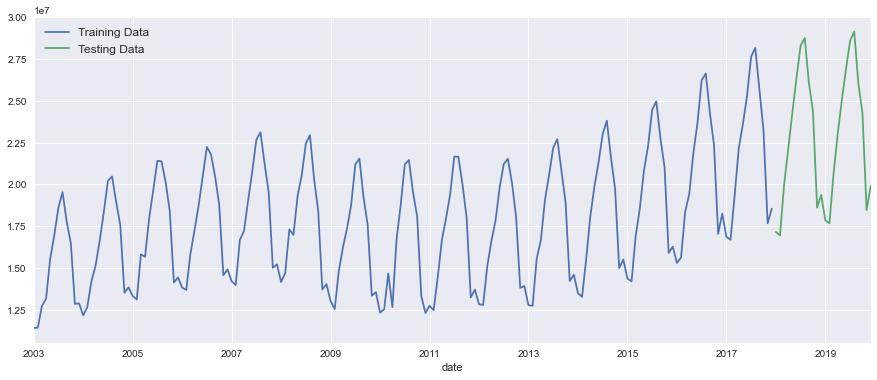

In [86]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")

plt.legend(fontsize=12)
plt.show()

---

## 5.2. Naive Forcasting

If we think the number of passengers have been stable from 2003, we could just take the last time period's number of passengers and estimate the same value for the next time period. Such a forecasting technique, which assumes that the next expected point is equal to the last observed point, is called a **naive method**.

In [87]:
# copy the test data
y_hat = flights_test.to_frame().copy()
# get the last training value and add this as a value for each
# test data
y_hat['naive'] = flights_train[len(flights_train)-1]
# demonstration
y_hat.head()

,vals,naive
date,,
2018-01-01,17153007.0,18548439.0
2018-02-01,16944281.0,18548439.0
2018-03-01,19990006.0,18548439.0
2018-04-01,22135672.0,18548439.0
2018-05-01,24297505.0,18548439.0


Lets have a look at the plot.

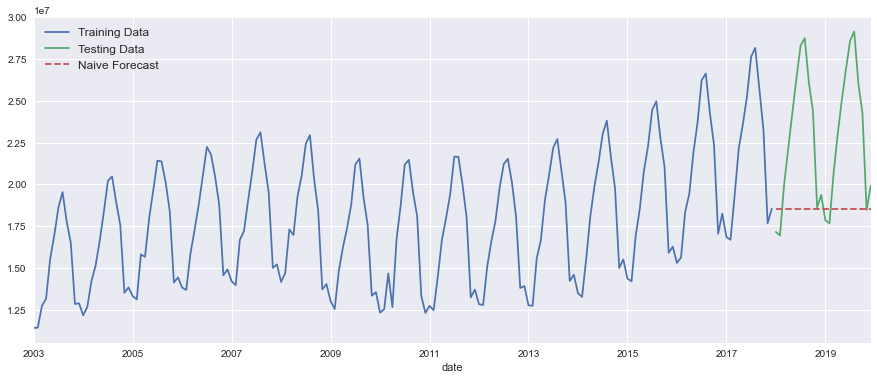

In [88]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")
y_hat['naive'].plot(label='Naive Forecast', linestyle="--")

plt.legend(fontsize=12)
plt.show()

We can use root mean-squared-error (RMSE) to check the accuracy of our model on the test data set. As a refresher, MSE takes the average of the squared distances between predicted points and the actual data. Outliers are 'punished' by the squaring done in the MSE while square-rooting the result will output a value that is in the same unit as the data (in our case, number of passengers on flights).

__Note:__ You can also do `squared = False` to get RMSE: `mean_squared_error(flights_test, y_hat['naive'], squared = False)`

In [89]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(flights_test, y_hat['naive']))
print('RMSE:', round(rmse,2))

RMSE: 5936911.66


Above means on average this model is wrong by nearly six million passengers between 2018 and 2020... so not a great model, although we probably could have expected that as the naive method isn’t suited for data sets with trends and seasonality!

---
## 5.3. Simple Average
Another simple model that assumes little variability (the values of interest are increasing and decreasing randomly by a small margin), and the average remains constant, is to compute a _Simple Average_. Simple average forecasts the number of flights of the next time period to be somewhat similar to the average of all of the previous time periods. 

In [90]:
# get the average of the training data
y_hat['avg_forecast'] = flights_train.mean()

y_hat.head()

,vals,naive,avg_forecast
date,,,
2018-01-01,17153007.0,18548439.0,1.777885e+07
2018-02-01,16944281.0,18548439.0,1.777885e+07
2018-03-01,19990006.0,18548439.0,1.777885e+07
2018-04-01,22135672.0,18548439.0,1.777885e+07
2018-05-01,24297505.0,18548439.0,1.777885e+07


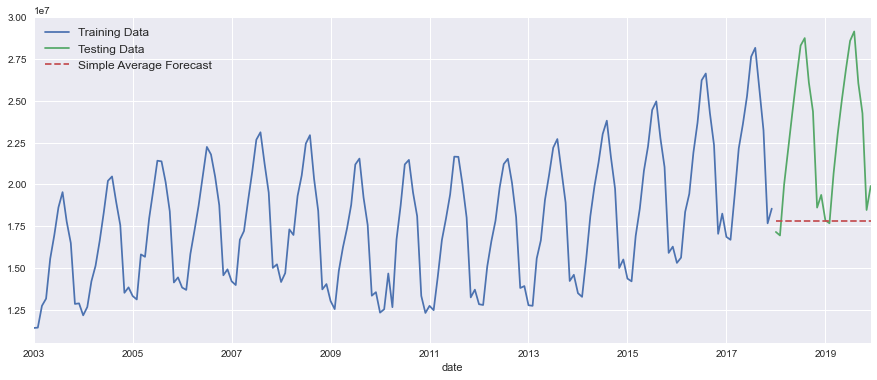

In [91]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")
y_hat['avg_forecast'].plot(label='Simple Average Forecast', linestyle="--")

plt.legend(fontsize=12)
plt.show()

Now, let's calculate RMSE to check to accuracy of our model.

In [92]:
rmse = np.sqrt(mean_squared_error(flights_test, y_hat['avg_forecast']))
print('RMSE:', round(rmse,2))

RMSE: 6523685.39


This model is even worse! Like the Naive method, the simple average method works best when the average at each time period remains constant but with our increasing trend this does not work very well! We're going to need to use some more advanced methods.

---

### 🚩 Exercise 20

On the `uk_rail_pass` data, get the RMSE of a naive and average model. How well do these perform?

__Note__
- You may as well use the same splits (i.e. checking how the model does on 2018 & 2019 data).

In [93]:
%run ../scripts/show_solutions.py 12_ex20

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

## 5.4. AutoRegressive (AR) forecasting

Let's look back at shifted data again below, this time only shifted for 1 lag. We can see each data point in the original data is close to its shifted one - so a basic forecast for the next data point could be to say it's simiar to the most recent value.

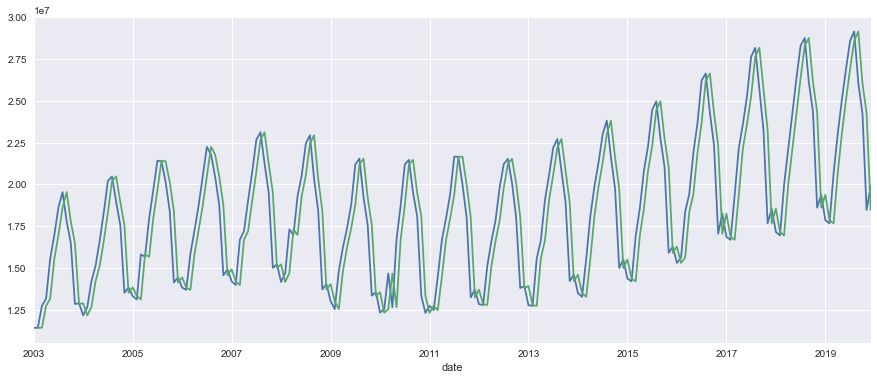

In [94]:
fig, ax = plt.subplots(figsize=(15,6))
uk_flight_pass.plot(ax=ax)
uk_flight_pass.shift(1).plot(ax=ax)
plt.show()

So lets use this assumption to make a really basic AR model to start with. All it will do is use the information from the previous lag to predict the next value. 

We will use an `ARIMA` model which takes three values in the parameter `order`, the AR, the differences, and the ME. We won't worry about using the differences or ME just yet, so lets just put 1 in the AR part (1 lag).

In [95]:
from statsmodels.tsa.arima.model import ARIMA

# fit our models
ARModel = ARIMA(flights_train, order=(1,0,0)).fit() # just using AR 

If we use `.summary`, we get tonnes of information out about the model! Lets just focus on the "Covariance Type" bit for now as this tells us the importance of each lag in our model. The lower the P-value the more important this component is to our model - typically we are looking for values under 0.05.

See here for more detail: 
- https://analyzingalpha.com/interpret-arima-results
- https://medium.com/analytics-vidhya/interpreting-arma-model-results-in-statsmodels-for-absolute-beginners-a4d22253ad1c

In [96]:
print(ARModel.summary())

                               SARIMAX Results                                
Dep. Variable:                   vals   No. Observations:                  180
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2863.592
Date:                Sun, 22 Jan 2023   AIC                           5733.183
Time:                        11:32:55   BIC                           5742.762
Sample:                    01-01-2003   HQIC                          5737.067
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.778e+07   9.25e+05     19.211      0.000     1.6e+07    1.96e+07
ar.L1          0.8549      0.044     19.647      0.000       0.770       0.940
sigma2      3.784e+12      0.900    4.2e+12      0.0

Looks like all the parts of the model are significant. Thats a good sign, it suggest we haven't put things in our model that are not really contributing. We want our models to ballance complexity with performance so making sure all the components in our model are useful is a good thing to check. 

Lets now look at our residuals to see the errors our model was making. First we'll need to make some predictions...

In [97]:
# get predition start and end dates
pred_start_date = flights_test.index[0]
pred_end_date = flights_test.index[-1]

# get predictions using a start and end date
predictions = ARModel.predict(start=pred_start_date, end=pred_end_date)

# demonstrate
display(predictions.head())

2018-01-01    1.843678e+07
2018-02-01    1.834133e+07
2018-03-01    1.825972e+07
2018-04-01    1.818995e+07
2018-05-01    1.813031e+07
Freq: MS, Name: predicted_mean, dtype: float64

...then get the residuals, which are just the difference between the real values and the predicted ones...

In [98]:
residuals = flights_test-predictions

# demonstrate
display(residuals.head())

date
2018-01-01   -1.283776e+06
2018-02-01   -1.397045e+06
2018-03-01    1.730287e+06
2018-04-01    3.945720e+06
2018-05-01    6.167198e+06
Freq: MS, dtype: float64

...and now lets plot them out.

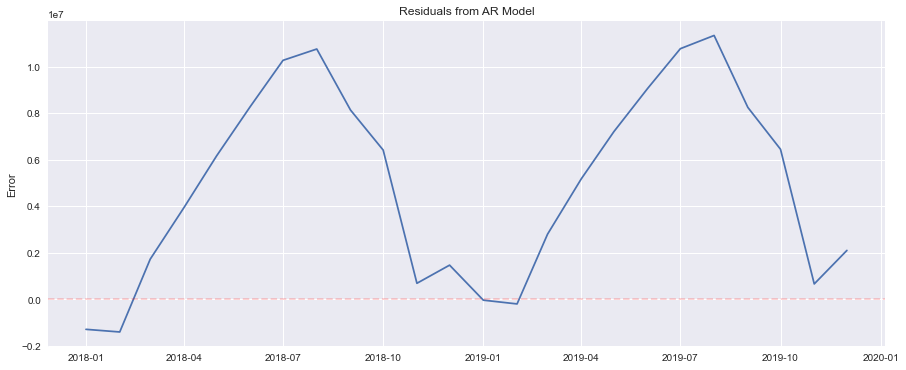

In [99]:
plt.figure(figsize=(15,6))
plt.plot(residuals)
plt.title("Residuals from AR Model")
plt.ylabel("Error")
plt.axhline(0, color="r", linestyle="--", alpha=0.2)
plt.show()

There is a pattern in the residuals which is not something we want as it suggests there is some dynamic(s) in the data we failed to capture. The model seems to be underestimating values and the residuals are not centred around 0. We can see this more clearly in the real data vs. the predictions.

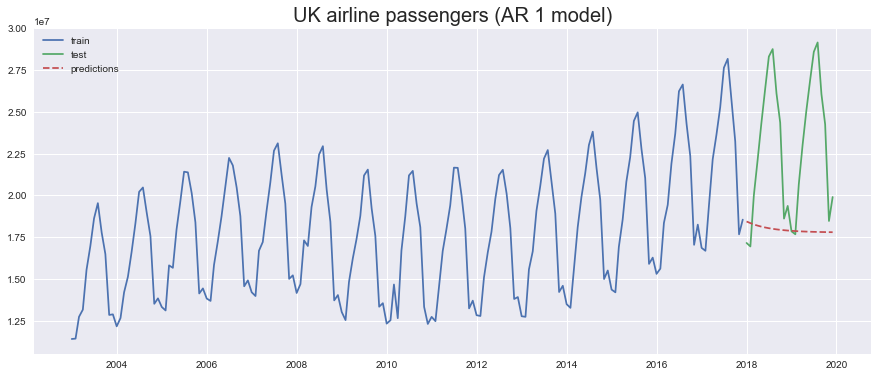

In [100]:
plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
plt.plot(predictions, label='predictions', linestyle="--")

plt.title("UK airline passengers (AR 1 model)", fontsize=20)

plt.legend(loc='best');

plt.show()

As the predictions get further from where we have data you see the model gets worse at predicting, this is often the case with timeseries models (e.g. its harder to predict something in 3 years time from now than next month). This uncertainty is best highlighted by looking at the confidence intervals. You can get them out the model using `.get_forecast`.

In [101]:
ARforecast = ARModel.get_forecast(flights_test.shape[0]).summary_frame()
ARforecast.head()

vals,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,1.843678e+07,1.945180e+06,1.462430e+07,2.224927e+07
2018-02-01,1.834133e+07,2.559134e+06,1.332552e+07,2.335714e+07
2018-03-01,1.825972e+07,2.927518e+06,1.252189e+07,2.399755e+07
2018-04-01,1.818995e+07,3.169796e+06,1.197727e+07,2.440264e+07
2018-05-01,1.813031e+07,3.335759e+06,1.159234e+07,2.466827e+07


Above we have the `mean`, which is our predictions (infact this is the same numbers as `.predict`), `mean_se`, an estimate of the standard deviation around this mean (we wont worry about this), and the `mean_ci_lower` and `mean_ci_upper` which our the lower and upper bounds for our 95% confidence intervals.

Its easier to visualise them so lets plot the confidence interval (red), which you can see fanning out from the first prediction. Essentially, after the first prediction the model gets very uncertain!

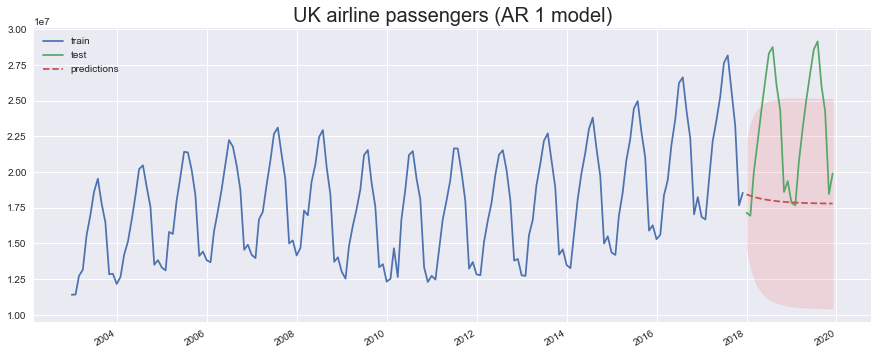

In [102]:
plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
ARforecast['mean'].plot(label='predictions', linestyle="--")

# add the confidence intervals by filling a colour between them
plt.fill_between(flights_test.index, ARforecast.mean_ci_lower, ARforecast.mean_ci_upper, color='red', alpha=0.1)

plt.title("UK airline passengers (AR 1 model)", fontsize=20)

plt.legend(loc='best')

plt.show()

If we evaluate this model as we did before we see that it is actually worse than just predicting 2018-2020's values will be like the last value in the training data (naive model).

In [103]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(flights_test, predictions))
print('RMSE:', round(rmse,2))

RMSE: 6416333.57


What we have so far is a really basic model. However it is probably important you don't just look at the last value, but the value before that as well, and use the information from both lags to compute the prediction.

An AR model uses this above logic when we use more than 1 lag, it looks at predicting future values as a linear combination (i.e., a sum of multiples of) recent values. Essentially, it's a linear regression on past values of the series.

__Note:__ [This video](https://www.youtube.com/watch?v=5-2C4eO4cPQ&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=9&ab_channel=ritvikmath) may be useful as a further explanation.

To find out how many lags may be useful for our prediction, we can use some of the information we gained from our EDA. Lets remind ourselves of what the partial autocorrelation looks like again.

__Note:__ For an AR model we look at the PACF for guidance not the ACF.

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


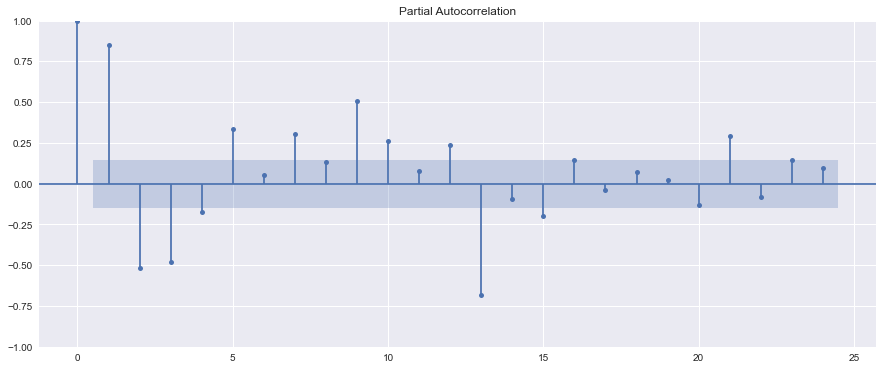

In [104]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(flights_train.dropna(), lags=24, ax = ax)

plt.show()

---
### 🚩 Exercise 21

Rather than a model that can only really predict the next months value, you want a model that can predict the number of passengers over the course of the next two years. Alter the AR order value from 1 to find a model that can do this more reliably using the information provided by the pacf above.

- Do you notice anything unexpected from the lags in the PCAF?

__Note:__ To make predictions 2 years in the future doesn't mean the order has to be 24.

In [105]:
%run ../scripts/show_solutions.py 12_ex21

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

## 5.5. MA forecasting

Forecasts aren't usually exactly right. Over time, we can look at how wrong we tend to be. If we consistently predict too high a value, we should lower our forecasts and if we consistently predict too low a value, we should raise our forecasts. So we can adjust our next forecast based on whether our most recent forecasts were overestimates or underestimates. 

Moving average forecasting is about taking the average (maybe weighted) of your most recent forecast errors and using them to adjust your next forecast.

__Note:__ [This video](https://www.youtube.com/watch?v=voryLhxiPzE&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=12) may be useful as a further explanation.

To decide on the order for the MA part of an ARIMA model, we now want to this time look at our ACF (not the PCAF).

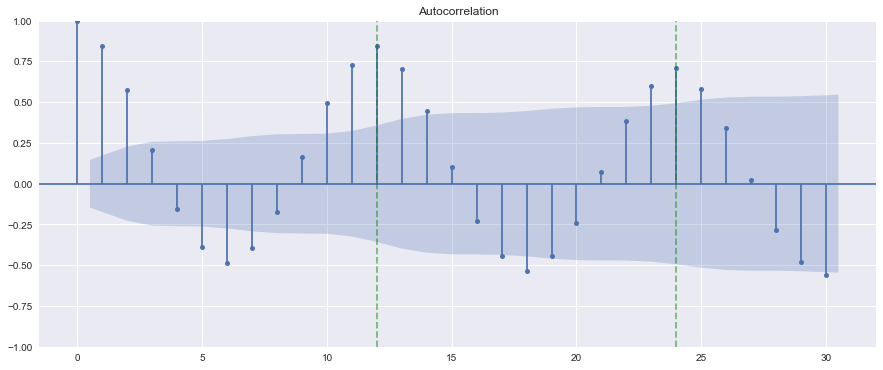

In [106]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(flights_train.dropna(), lags=30, ax = ax)
plt.axvline(x=12, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=24, color='g', linestyle='--', alpha=0.5)
plt.show()

Lets use a MA model of order 12. An important note when just using an MA model is, unlike an AR only model, our order determines how many future datapoints we can predict in the future, so here we can only predict 12 future datapoints. Any more than 12 it will just predict the mean.

In [107]:
MAModel = ARIMA(flights_train, order=(0,0,12)).fit() # just using MA
print(MAModel.summary())

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   vals   No. Observations:                  180
Model:                ARIMA(0, 0, 12)   Log Likelihood               -2902.069
Date:                Sun, 22 Jan 2023   AIC                           5832.138
Time:                        11:32:56   BIC                           5876.839
Sample:                    01-01-2003   HQIC                          5850.262
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.778e+07   4.25e+06      4.181      0.000    9.44e+06    2.61e+07
ma.L1          1.0143      0.803      1.263      0.207      -0.560       2.588
ma.L2          1.0759      1.146      0.938      0.3

So above we can see that some of our terms in the model are useful, but some of them aren't. So our predictive model is:

$$\hat y_t = 1.778e7 + 1.0143_{\epsilon_ {t-1}} + 1.0759_{\epsilon_ {t-2}} ... + -0.4210_{\epsilon_ {t-12}} $$

Lets have a look at a plot of how it does...

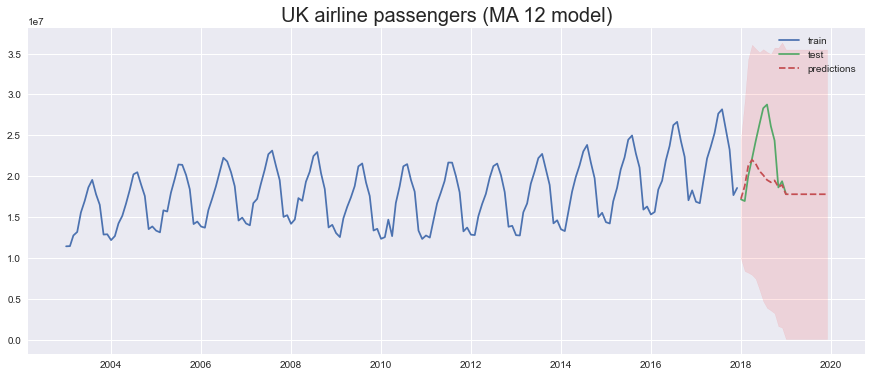

In [108]:
# get predictions and confidence intervals
MAforecast = MAModel.get_forecast(flights_test.shape[0]).summary_frame()

plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test.loc[:flights_test.index[12]], label='test')
plt.plot(MAforecast['mean'], label='predictions', linestyle="--")

# add the confidence intervals by filling a colour between them
plt.fill_between(flights_test.index, MAforecast.mean_ci_lower, MAforecast.mean_ci_upper, color='red', alpha=0.1)

plt.title("UK airline passengers (MA 12 model)", fontsize=20)

plt.legend(loc='best')

plt.show()

...the actual predictions are not as bad as some other previous models but certainly not great (i.e. massive confidence intervals). The reason is likely because the data is not centred around the mean (it has trends), so this model isn't really that useful on its own...

---

## 5.6. ARMA forecasting

We could try combining AR and MA models to get ARMA forecasting! You predict the next value to be a linear combination of the most recent values (AR), plus a "correction term" which is an average of the most recent errors (MA).

$$y_{t} = c + (a_1y_{t-1} + a_2y_{t-2} + ... + a_py_{t-p}) + (b_1\epsilon_{t-1} + b_2\epsilon_{t-2} + ... + b_q\epsilon_{t-q}) + \epsilon_t$$

__Note:__ [This video](https://www.youtube.com/watch?v=HhvTlaN06AM&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=17) may be useful as a further explanation.

                               SARIMAX Results                                
Dep. Variable:                   vals   No. Observations:                  180
Model:                ARIMA(1, 0, 12)   Log Likelihood               -2810.410
Date:                Sun, 22 Jan 2023   AIC                           5650.821
Time:                        11:32:58   BIC                           5698.715
Sample:                    01-01-2003   HQIC                          5670.240
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.778e+07   2.09e+06      8.494      0.000    1.37e+07    2.19e+07
ar.L1          0.8336      0.201      4.157      0.000       0.441       1.227
ma.L1          0.1171      0.322      0.364      0.7

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


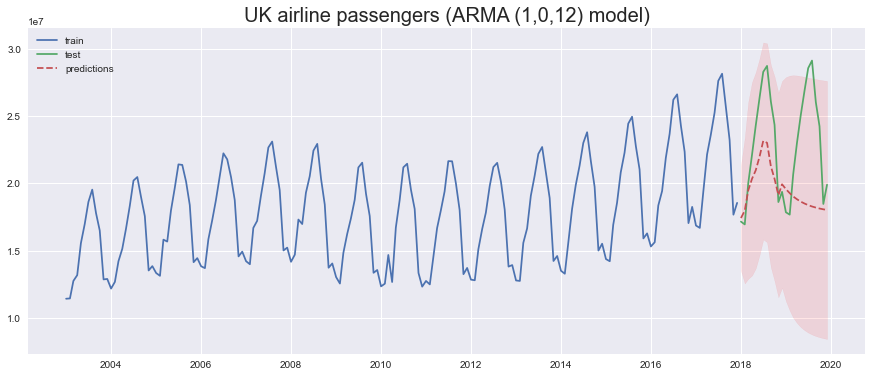

In [109]:
ARMAModel = ARIMA(flights_train, order=(1,0,12)).fit() # just using ARMA
print(ARMAModel.summary())

# get predictions and confidence intervals
ARMAforecast = ARMAModel.get_forecast(flights_test.shape[0]).summary_frame()

plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
plt.plot(ARMAforecast['mean'], label='predictions', linestyle="--")

# add the confidence intervals by filling a colour between them
plt.fill_between(flights_test.index, ARMAforecast.mean_ci_lower, ARMAforecast.mean_ci_upper, color='red', alpha=0.1)

plt.title("UK airline passengers (ARMA (1,0,12) model)", fontsize=20)

plt.legend(loc='best');

plt.show()

...better but still not right. Like the AR model it may look better if we do a rolling forcast but lets continue to move on to learning about even better models!

--- 
## 5.7. ARIMA forecasting

One of the reasons our models so far have not been great is ARMA models only properly work on stationary time series. 

A time series is "stationary" if it looks basically centered around some number - so no trend, no seasonality, homoskedastic. This means that...

...the mean of the series should not be a function of time, but rather constant...

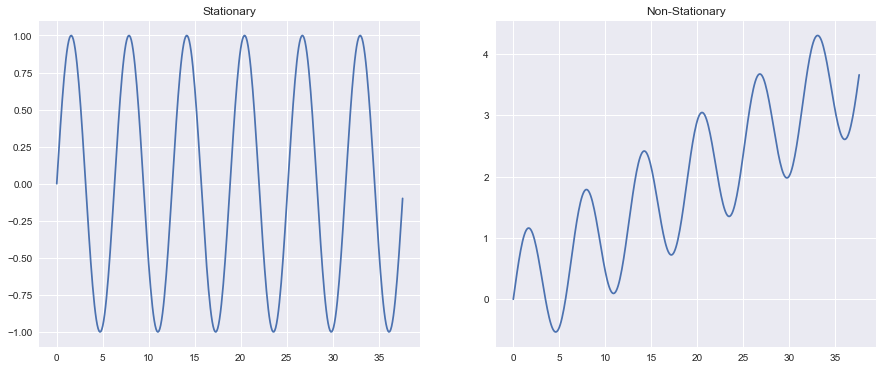

In [110]:
x = np.arange(0,12*np.pi,0.1)   # start,stop,step
y = np.sin(x)

adding = list(range(0,len(y)))
adding[:] = [x / 100 for x in adding]
y_ = y+adding

fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(x,y)
ax[0].set_title("Stationary")
ax[1].plot(x,y_)
ax[1].set_title("Non-Stationary")

plt.show()

...the variance of the series should not be a function of time (homoscedasticity)...

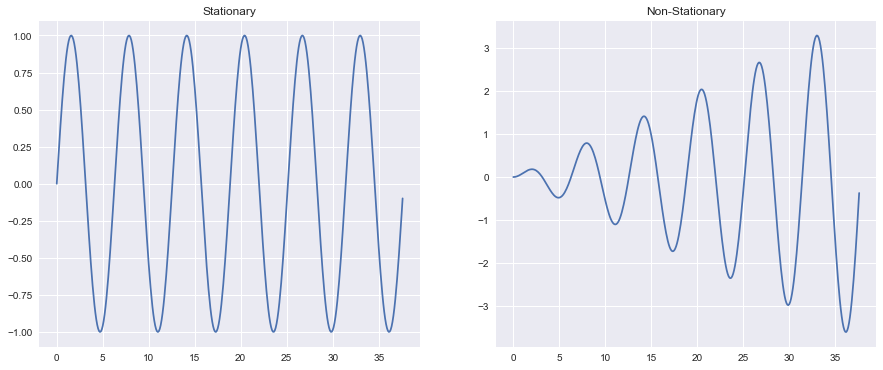

In [111]:
x = np.arange(0,12*np.pi,0.1)   # start,stop,step
y = np.sin(x)

adding = list(range(0,len(y)))
adding[:] = [x / 100 for x in adding]
y_ = y*adding

fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(x,y)
ax[0].set_title("Stationary")
ax[1].plot(x,y_)
ax[1].set_title("Non-Stationary")

plt.show()

...and the covariance of the `i`th term and the `(i + m)`th term should not be a function of time (i.e. the spread shouldnt change).

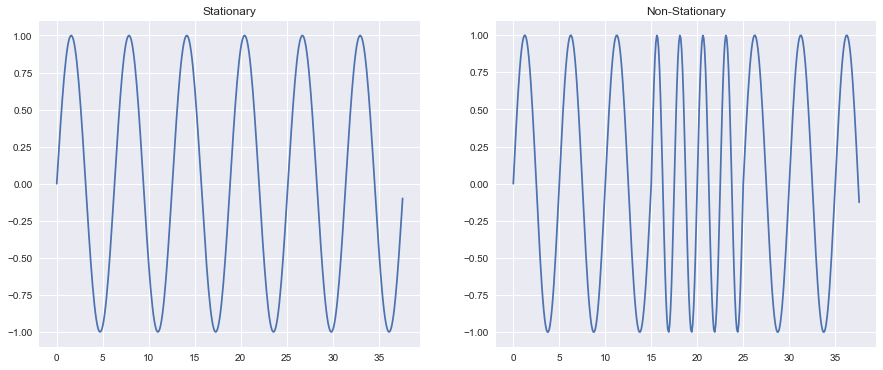

In [112]:
x = np.arange(0,12*np.pi,0.1)   # start,stop,step
y = np.sin(x)

# https://dsp.stackexchange.com/questions/81140/how-can-i-generate-a-sine-wave-with-time-varying-frequency-that-is-continuous-in
# define the three frequencies in radians per sample
omegaT1 = 2*np.pi*.2*0.1
omegaT2 = 2*np.pi*.4*0.1
omegaT3 = 2*np.pi*.2*0.1
y_=list()
phi = 0; # phase accumulator
for i in range(0,len(x)):
    c = np.sin(phi) # cosine of current phase
    y_.append(c)
    # increment phase based on current frequency
    if x[i]<15:
       phi = phi + omegaT1
    elif x[i]<25:
       phi = phi + omegaT2
    else:
       phi = phi + omegaT3

fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(x,y)
ax[0].set_title("Stationary")
ax[1].plot(x,y_)
ax[1].set_title("Non-Stationary")

plt.show()

The reason it is important to know if your data is stationary or not is many time-series models (including AR, MA, ARMA, etc.) work on the assumption that the time series is stationary. Essentially they assume that if a time series has a particular behaviour over time in the past, there is a high probability that it will act similarly in the future. 

The issue with real data, is these assumptions do not always hold as we can see with our airline passenger data. Below we can see that our data has both a non-constant mean (i.e. it has a trend) and some slight variance changes over time.

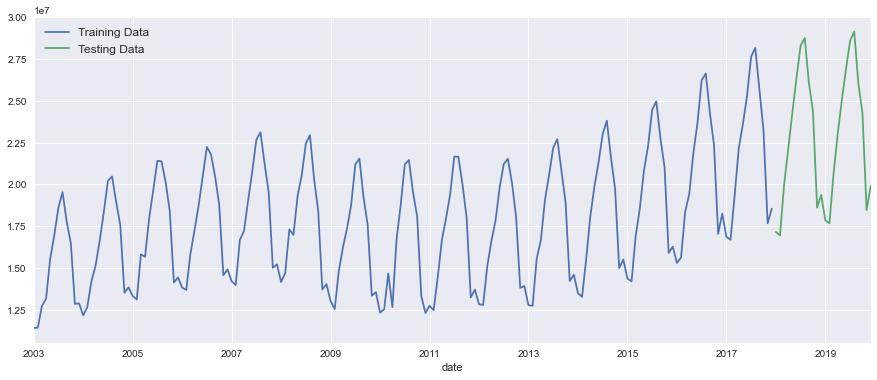

In [113]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")

plt.legend(fontsize=12)
plt.show()

We could also use a stationary test to futher confirm this is the case, such as a Augmented Dickey-Fuller test.

__Null Hypothesis:__ Our data is _not stationary_

__Alternate Hypothesis:__ Our data is _stationary_

We will test this at the 5% level.

In [114]:
from statsmodels.tsa.stattools import adfuller

print('p-value:' +str(round(adfuller(flights_train)[1], 2)))

p-value:0.95


As we learnt previously, we can use differencing to remove the trend and to reduce the change in variance we can take the log. The resulting time-series we then try to predict is the following...

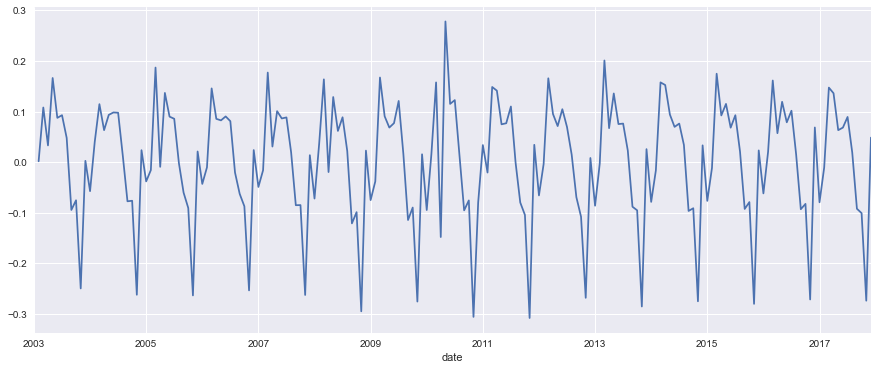

In [115]:
stationary_flights_train = np.log(flights_train).diff()

stationary_flights_train.plot(figsize=(15,6))
plt.show()

... which we can see is now stationary.

In [116]:
stationary_flights_train = stationary_flights_train.dropna() # first value of the .diff is an NA

print('p-value:' +str(round(adfuller(stationary_flights_train)[1], 2)))

p-value:0.04


The good thing about using a log and difference to make our data more stationary is it is easily reversible. Once we make our predictions on the stationary data we can do the inverse of the difference and the log to get the predictions on the original scale. 

When putting this into practice, the ARIMA function already does the differencing for us in the model (so we don't need `.diff`) as the I stands for "integration" which is the reverse of differencing. This means all we will do to the data is a log transformation.

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


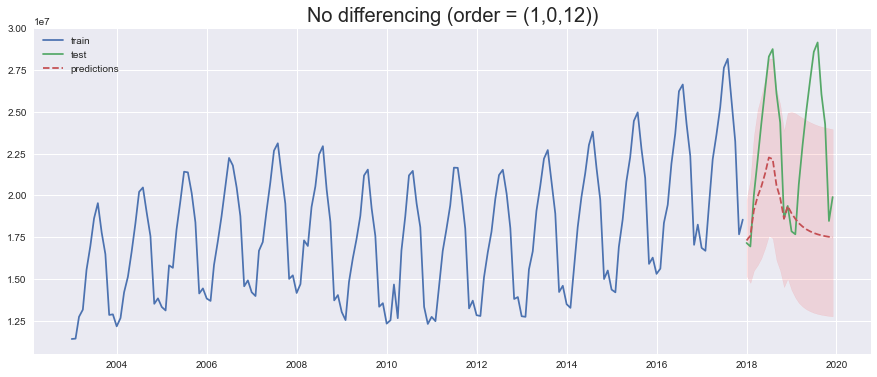

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


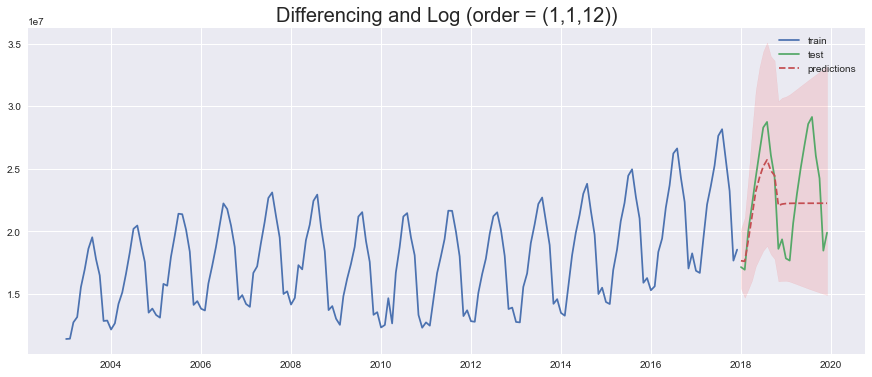

In [117]:
diff_dict = {"No differencing (order = (1,0,12))": (1,0,12), 
             "Differencing and Log (order = (1,1,12))":(1,1,12)}

for title in diff_dict:

    ARIMAModel = ARIMA(np.log(flights_train), # log transforming the data with np.log
                       order=diff_dict[title]).fit()
    
    # get predictions and confidence intervals
    ARIMAforecast = ARIMAModel.get_forecast(flights_test.shape[0]).summary_frame()

    plt.figure(figsize=(15,6))

    plt.plot(flights_train, label='train')
    plt.plot(flights_test, label='test')
    plt.plot(np.exp(ARIMAforecast['mean']),       # undo the log with np.exp
             label='predictions', linestyle="--")

    # add the confidence intervals by filling a colour between them
    plt.fill_between(flights_test.index, 
                     np.exp(ARIMAforecast.mean_ci_lower), 
                     np.exp(ARIMAforecast.mean_ci_upper), 
                     color='red', alpha=0.1)

    plt.title(title, fontsize=20)

    plt.legend(loc='best')

    plt.show()

...so the model is getting better (the real values are inside the confidence interval when we use intergration) and we could continue to tweek the order values to get a better model. Lets look at our pacf and acf again with the more stationary (log and differenced) data to give us an idea of what values we might want to choose.

__Note:__ Notice how making the data more stationary makes the seasonality more pronounced.

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


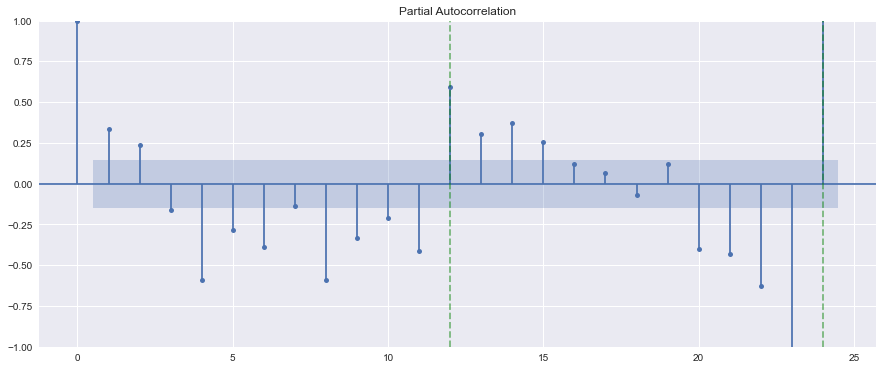

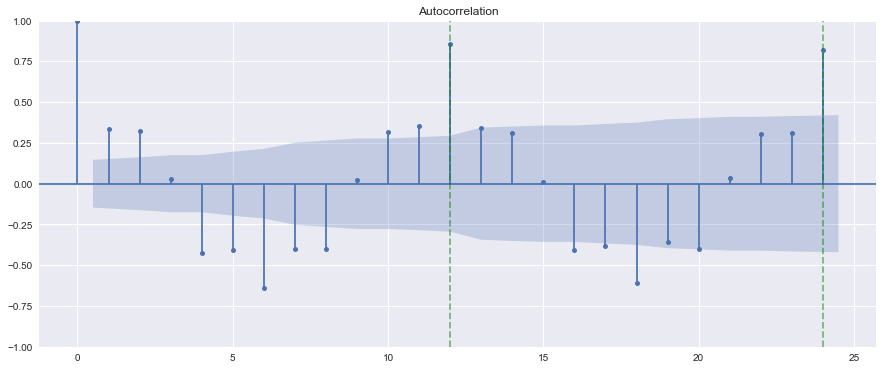

In [118]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(np.log(flights_train).diff().dropna(), lags=24, ax = ax)
plt.axvline(x=12, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=24, color='g', linestyle='--', alpha=0.5)

plt.show()

fig, ax = plt.subplots(figsize=(15,6))
plot_acf(np.log(flights_train).diff().dropna(), lags=24, ax = ax)
plt.axvline(x=12, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=24, color='g', linestyle='--', alpha=0.5)

plt.show()

---

### 🚩 Exercise 23

Find a better ARIMA model for the airline passengers data by adjusting the AR and MA orders in the `ARIMA` model.

__Note:__ Remember the lags outside of the shaded region give you an idea of what may be useful. The PACF for the order for the AR bit and the ACF for the MA bit.

In [119]:
%run ../scripts/show_solutions.py 12_ex23

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
One thing you may have noticed in the previous exercise is when increasing the AR and MA values, you get components of your model with high p-values. This means they are not really significantly contributing to the model. This means we have some redundency in there and you have an overly complex model.

Indeed if you brought the AR order to 12 or above you may have noticed that this is one of the only significant parts of your model. This is because we are missing something really important - explicitly dealing with the seasonal 12 monthly trend! So rather than have all lags from 1-12 in there, why not just use 12?

__Note:__ You may have also noticed we have been getting warning messages when training our models which until now we have been ignoring... this is another good sign the model could be improved.

---

## 5.8. SARIMA

SARIMA just adds an extra part which is the seasonality. This is the spike in the `pacf` and `acf` at 12 months.

To get this seasonal component using this model we need to add a `seasonal_order`. This is quite frankly similar to the `order` but has an extra part. 

<ul>
    <li><b>P</b>- Seasonal autoregressive order</li>
    <li><b>D</b>- The number of differences needed to make the seasonal part of the time series stationary </li>
    <li><b>Q</b>- Seasonal moving average order</li>
    <li><b>M</b>- How many observations to include in a season (i.e. 12 for monthly data with a yearly season)</li>
</ul>

So our complete model will have the following orders: (p, d, q)(P, D, Q, M).

To find P, D and Q we follow the same process as before, only this time we need to look only at the seasonal part of the data, which we can find using the `seasonal_decompose` function we've used before.

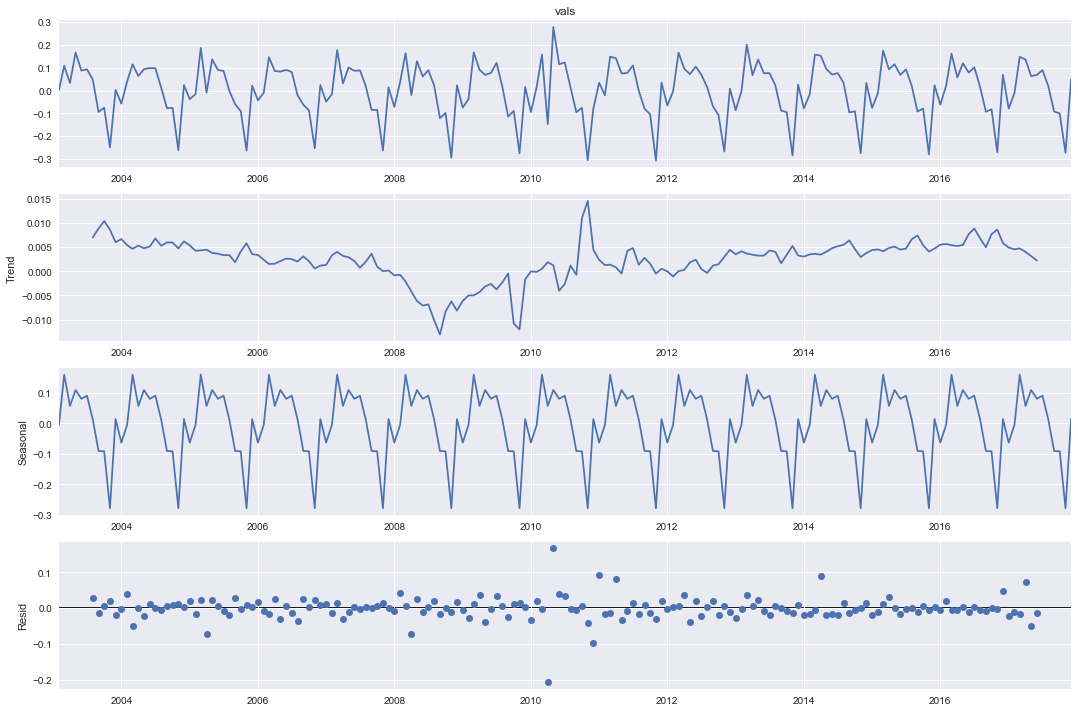

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose

flight_decomp = seasonal_decompose(stationary_flights_train, period=12)  

fig = flight_decomp.plot()
fig.set_size_inches((15,10))
fig.tight_layout() # Tight layout to realign things
plt.show()

We can extract just the seasonal component from this decomposition

In [121]:
flight_seasonal=flight_decomp.seasonal

We can now check if this is stationary

In [122]:
result_season = adfuller(flight_seasonal)
print('p-value:' +str(result_season[1]))

p-value:0.0


Seems to be so probably no need to difference the seasonal part before checking our ACF and PACF plots.

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


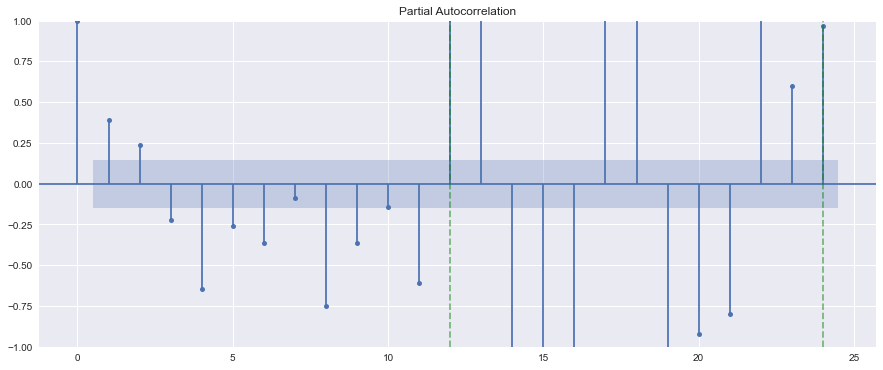

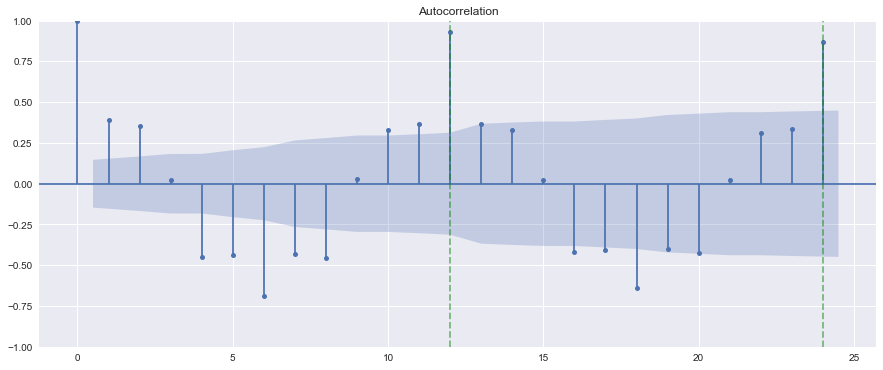

In [123]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(flight_seasonal, lags=24, ax = ax)
plt.axvline(x=12, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=24, color='g', linestyle='--', alpha=0.5)

plt.show()

fig, ax = plt.subplots(figsize=(15,6))
plot_acf(flight_seasonal, lags=24, ax = ax)
plt.axvline(x=12, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=24, color='g', linestyle='--', alpha=0.5)

plt.show()

From above it looks like lots of lags in this part of the model could also be useful. However rather than make a really complex model lets first look at something relatively simple (simplicity is generally better).

__Note:__ 
- Notice below how we set the number of differences needed to make the seasonal part of the time series stationary to 0 as this was shown to be stationary.

In [140]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# we are not going to worry about the X part in SARIMAX

order = (1,1,1)
seasonal_order = (1,0,1,12)
SARIMAModel = SARIMAX(np.log(flights_train), order=order, seasonal_order=seasonal_order).fit()

print(SARIMAModel.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               vals   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 332.174
Date:                            Sun, 22 Jan 2023   AIC                           -654.348
Time:                                    11:39:24   BIC                           -638.411
Sample:                                01-01-2003   HQIC                          -647.886
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2605      0.100      2.613      0.009       0.065       0.456
ma.L1         -0.7306      0.065   

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


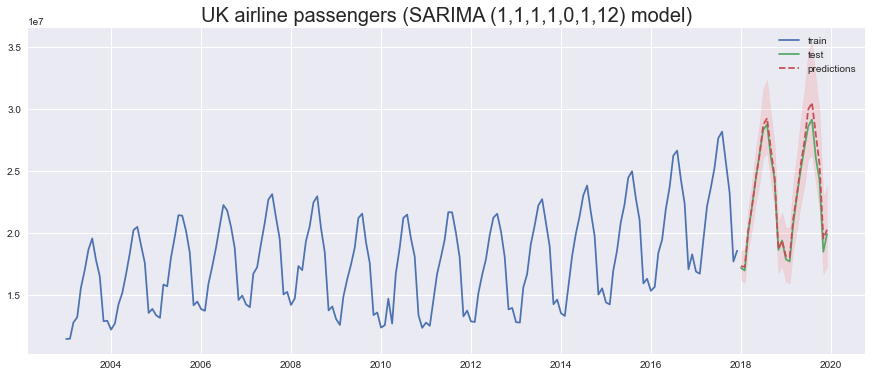

In [141]:
SARIMAforecast = SARIMAModel.get_forecast(flights_test.shape[0]).summary_frame()

plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
plt.plot(np.exp(SARIMAforecast['mean']), 
         label='predictions', linestyle="--")

# add confidence intervals
plt.fill_between(flights_test.index, 
                 np.exp(SARIMAforecast.mean_ci_lower), 
                 np.exp(SARIMAforecast.mean_ci_upper), 
                 color='red', alpha=0.1)

plt.title("UK airline passengers (SARIMA (1,1,1,1,0,1,12) model)", fontsize=20)

plt.legend(loc='best')

plt.show()

In [142]:
rmse = np.sqrt(mean_squared_error(flights_test, np.exp(SARIMAforecast['mean'])))
print('RMSE:', rmse.round(2))

RMSE: 707771.24


This looks like a good model that balances complexity and performance! The components of our model are all significant so this is good.

---
## 5.9. Auto-SARIMA

So we've been improving our model so far by manually altering the hyperparameters. However, now we know what those parameters mean, if you think to how we set hyperparameters in other machine learning models (demonstrated in other workbooks), we often do some optimisation to find them (e.g. gridsearch). We can do the same thing with our time-series models.

The library `pmdarima` contains a function named `auto_arima` which implements the ARIMA/SARIMA models but can automatically find optimal values for all parameters (p, d, q, P, D, and Q).

__Note__
- Setting `trace=True` prints the output below. This is very useful since the `auto_arima` model can take a while to  compute several combination of parameters, and by looking at the printout we can see that the model is busy but not hanging.
- You can look over more parameter values, but this will increase the search time.

In [125]:
# import pmdarima, which is the library we use for the auto_arima function
import pmdarima as pm

autoarima_model = pm.auto_arima(np.log(flights_train),
                                trace=True,  # prints the search for optimal parameters
                                seasonal=True,  # whether our dataset displays seasonality or not
                                m=12,  # number of observations per seasonal cycle (i.e. seasonality)
                                random_state = 42 # ensures replicable results
                               )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-655.142, Time=1.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-525.151, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-623.526, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-660.163, Time=0.76 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-589.419, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-659.463, Time=0.84 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-659.126, Time=1.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-640.511, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-657.611, Time=2.92 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-628.449, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-658.850, Time=0.78 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-658.969, Time=1.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-648.356, Time=0.46 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-657.807, Time=1.00 sec
 ARIMA(0,1,1)(0,1,1

You can see above, by default `auto_arima` is minimising a metric called AIC. Without worrying about the details too much, essentially AIC takes the error term and adds a penalty related to the number of predictors used in the model. This means more complex models are penalised, so a good model strikes a ballance between accuracy and simplicity. Indeed you can see this model has no AR component!

Now lets see how our best model (as shown above) has done.

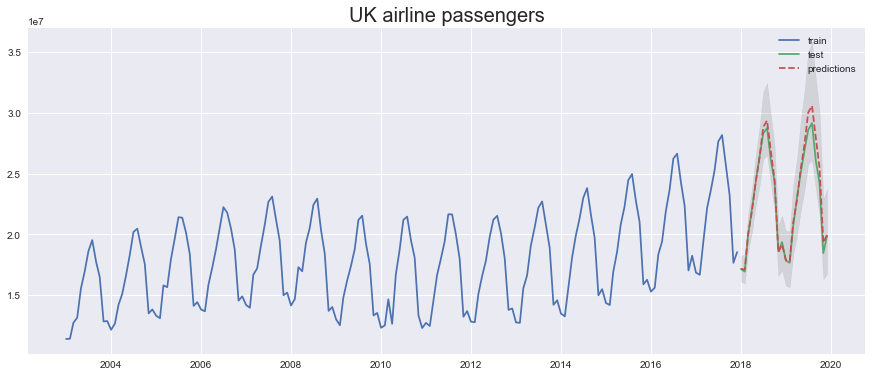

RMSE: 696751.92


In [126]:
# predicting the same number of points as our forecast_period defined above
autoarima_forecast, conf_int = autoarima_model.predict(
    n_periods=len(flights_test),
    return_conf_int=True)  # this returns a second value for confidence interval

plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
plt.plot(np.exp(autoarima_forecast), 
         label='predictions', linestyle="--")

# plot the confidence intervals on the forecasts
plt.fill_between(autoarima_forecast.index, 
                 np.exp(conf_int[:, 0]), 
                 np.exp(conf_int[:, 1]), 
                 color='k', 
                 alpha=0.1)

plt.title("UK airline passengers (auto-ARIMA)", fontsize=20)

plt.legend(loc='best')

plt.show()

rmse = np.sqrt(mean_squared_error(flights_test, np.exp(autoarima_forecast)))  # using np.exp() to cancel the log transformation
print('RMSE:', rmse.round(2))

---

### 🚩 Exercise 25

Create a SARIMA (or auto-SARIMA) model for forcasting the `uk_rail_pass` data.

In [127]:
%run ../scripts/show_solutions.py 12_ex25

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
## 6. Deployment <a id='deploy'></a>

The models we have built above have all been trained on a subset of the data, and tested with the rest to see how accurate they were. Once we are happy with a model we can then update with the test data and use it to predict future values we don't yet have.

If your best model is one you have created using `statsmodels`, then you will need to retrain the model with its best parameters but all the data.

In [128]:
order = (0,1,1)
seasonal_order = (0,1,1,12)
SARIMAModel = SARIMAX(np.log(uk_flight_pass), order=order, seasonal_order=seasonal_order).fit()

If your best model was the one created using `auto_arima` you can use `.update`.

__Note:__ This works like `inplace` so automatically updates the `autoarima_model` without assignment.

In [129]:
# update the model with the test data
autoarima_model.update(np.log(flights_test))

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

Either way, both have `.predict` to predict future values.

__Note:__ To get confidence intervals from the `statsmodels` models you need to use `.get_forecast` like we have been doing previously.

In [130]:
# create a range of dates for the next two years
forecast_period = pd.date_range(start=flights_test.index[-1] + pd.DateOffset(months=1),
                                periods=24,
                                freq="MS")

# predicting the same number of points as our forecast_period defined above
future_forecast, future_conf_int = autoarima_model.predict(n_periods=len(forecast_period),
                                                           return_conf_int=True)
# add the index to the forecast in a pandas series
future_forecast = pd.Series(future_forecast, index = forecast_period)

future_forecast.head()

2020-01-01    16.711958
2020-02-01    16.705696
2020-03-01    16.866914
2020-04-01    16.960515
2020-05-01    17.058716
Freq: MS, dtype: float64

Lets have a look at how we did...

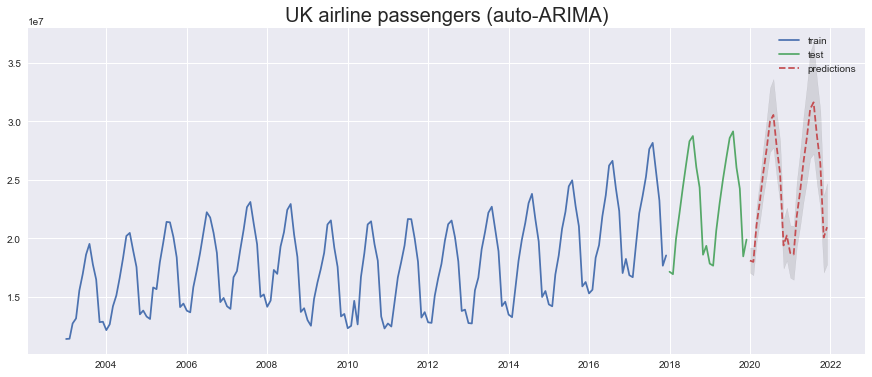

In [143]:
plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
plt.plot(np.exp(future_forecast), label='predictions', linestyle="--")

# plot the confidence intervals on the forecasts
plt.fill_between(forecast_period, 
                 np.exp(future_conf_int[:, 0]), 
                 np.exp(future_conf_int[:, 1]), 
                 color='k', 
                 alpha=0.1)

plt.title("UK airline passengers (auto-ARIMA)", fontsize=20)

plt.legend(loc='best')

plt.show()

As you can see we now have an idea of what the future number of passengers should look like in 2020-2022. However we need to take these predictions with a degree of caution. Why? Well think about what happened in 2020, passengers on slights plummeted and the real number of passengers will look nothing like our forecast. Our predictions are always going to be based on assuming the future trends will be similar to those seen in the past, something we know didn't end up happening. these forecasts instead could be used as targets or benchmarks that you can use to compare real values. 

Also, remember, the further into the future you predict, the more unreliable it is. So take this into consideration as well.

Like most modelling, forecasting is not a one-and-done process. You will need to rebuild the model everytime new data comes in to see if that changes the forecast and check the model isn't considerably loosing its performance.

---

## 6.1. Saving our models

Like `scikit-learn` models before, we can save and load our model using either `joblib` or `pickle`. Here I will demonstrate pickle...

In [132]:
import pickle

modelPath = os.path.join(os.path.curdir, "Model", "UK_flights_autoarima.pkl")

# Serialize with Pickle
with open(modelPath, 'wb') as pkl:
    pickle.dump(autoarima_model, pkl)

You can load it as so...

In [133]:
# Now read it back
with open(modelPath, 'rb') as pkl:
    autoarima_model = pickle.load(pkl)

Saving our models in this way allows us to transfer them between different users or incorperate into a pipeline.

---
# 7. Summary <a id='sum'></a>

For the sake of this workbook you are now done - well done! 

Hopefully you feel we have addressed the aim of getting intorduced to time-series forecasting.

This workbook we worked through a number of the steps required as part of a time-series forecasting project. In summary these are alike to all machine learning projects in that you start with framing the problem, getting the data, and exploring it, but specifically...

1. Perform a __test train split__ on the dataset (first roughly 80% to decide on parameters, last 20% to see how well the model performs). 
2. __Identify if your data is stationary__ or not. To do this check for trends, seasonality, and heteroskedasticity. If the data is seasonal, what is the seasonal period? To help with this you will likely want to use a ACF/PACF plots and/or seasonal decomposition.
3. __Prepare your data for modelling__. If it has trends you may want to difference the data. If it is heteroskedastic, transform the data to make it homoskedastic (e.g. take the logarithm).
4. __Create baseline model(s)__ to compare performance against (e.g. Naive or simple mean).
5. Manually __investigate parameters__ for more sophisticated models (e.g. SARIMA) based on your EDA, and/or use an automatic parameter selection method (e.g. auto-arima). __Evaluate your model performance__, using training data to build your model(s) and comparing to validation/test data.
6. Once you have settled on a model, __train it on the whole dataset__ to produce your forecast.

---

# 8. Extra <a id='extra'></a>

Below is some extra information and tasks that you may find useful.

---

## 8.1. Rolling Forecasts

However how would we use this model in reality? We may want to just predict the number of passengers expected in the next month rather than for the full year anyway. In this case we could instead evaluate how it performs predicting one month in advance in a loop. This is called a rolling forecast.

In [134]:
from datetime import timedelta

predictions_rolling = pd.Series(dtype ='float64')
for end_date in flights_test.index:
    train_data_ = uk_flight_pass[:end_date - pd.DateOffset(months=1)]
    model_fit_ = ARIMA(train_data_, order=(1,0,0)).fit()
    pred_ = model_fit_.predict(end_date)
    predictions_rolling.loc[end_date] = pred_.loc[end_date]
    
residuals_rolling = flights_test - predictions_rolling

Now we see below our residuals are centered around 0 and have less systematic error...

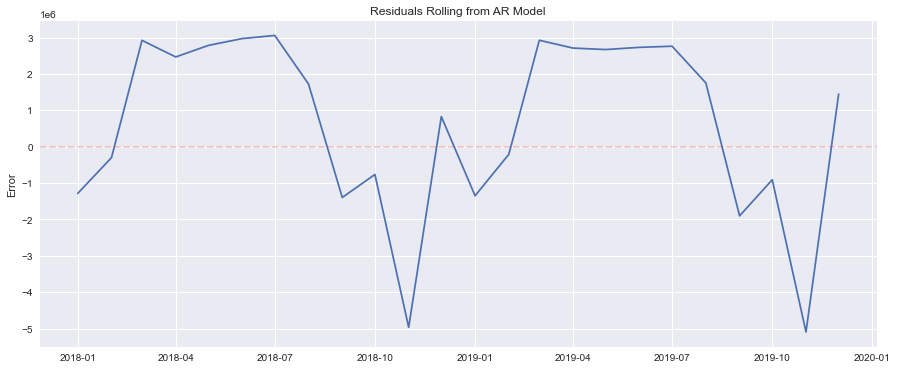

In [135]:
plt.figure(figsize=(15,6))
plt.plot(residuals_rolling)
plt.title("Residuals Rolling from AR Model")
plt.ylabel("Error")
plt.axhline(0, color="r", linestyle="--", alpha=0.2)
plt.show()

...and now our predictions from this simple model actually look quite good. So provided we retrain and then predict 1 month in advance each time we used this model in practice, this model would actually be okay (although by no means amazing). In otherwords, think about how far in the future your model would need to predict when evaluating its performance.

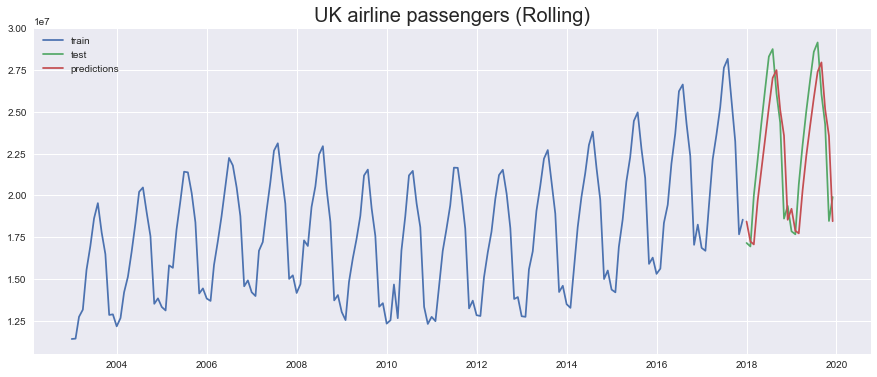

In [136]:
plt.figure(figsize=(15,6))

plt.plot(flights_train, label='train')
plt.plot(flights_test, label='test')
plt.plot(predictions_rolling, label='predictions')

plt.title("UK airline passengers (Rolling)", fontsize=20)

plt.legend(loc='best');

plt.show()

---

### 🚩 Exercise 22 (Extra)

An AR model with more lags, with its added complexity, may also be useful to be used to predict the next three months of flights. Check its performance if repeatedly used every three months to predict the next three months of flights thoughout 2018 and 2019. 

In [137]:
%run ../scripts/show_solutions.py 12_ex22

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 24 (extra)

Lets now get a rolling forecast for the SARIMA model to see how the model would do if it were to just predict one month ahead and evaluate its performance.

In [138]:
%run ../scripts/show_solutions.py 12_ex24

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

### Cross-validation

### 🚩 Extra Exercise

Using the "Air passenger transport by main airports in each reporting country (avia_paoa)" data on the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view), try forcast the passenger numbers for your closest (or desired) airport.

**Note**
- This data is larger!

In [139]:
%run ../scripts/show_solutions.py 12_ex99

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

__TODO:__ 
- better plot titles
- Cross-validation?
- You don't really come back to COVID data at the end. Add that as an extra thing showing how difficult it is.
- Move rolling stuff into here
- Holt winters into here (ETS in statsmodels? https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html) This is more inline with the other `.summary` outputs. 
- Then you can go into auto-arima from there and help with informing, then go back into manual Arima selection